In [1]:
import logging

import tensorflow as tf
from sklearn.base import BaseEstimator

from tensorflow import keras
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten, MaxPool2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from DeepCCA.cca_layer import CCA

import nni

import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer

from dataset import DataReader
# from sample import BalancedSample

_logger = logging.getLogger('[SHL Challenge]')
_logger.setLevel(logging.INFO)


tf.random.set_seed(1234)
np.random.seed(1234)

In [2]:
def dict_of_params(params):
    """
    Transforms a flattened dictionary, given in `params`, into
    an easy-to-access nested dictionary, e.g.:
    input:
        params = {
            'Acc_numfilters_0': 32
            [...]
        }

    result:
        params = {
            'Acc': {
                'numfilters': {
                        '0': 32,
                        '1': 9
                }
            [...]
        }
    """
    ret = {}
    for key, val in params.items():
        a, b, c = key.split('_')
        if a not in ret:
            ret[a] = {}
        if b not in ret[a]:
            ret[a][b] = {}
        ret[a][b][c] = val
    return ret

In [3]:
params = {  # best arch so-far (eVj1A-189) from tehran_1
    'Acc_numfilters_0': 64,
    'Acc_kernelsize_0': 11,
    'Acc_numfilters_1': 32,
    'Acc_kernelsize_1': 5,
    'Acc_numfilters_2': 32,
    'Acc_kernelsize_2': 2,

    'Gyr_numfilters_0': 64,
    'Gyr_kernelsize_0': 17,
    'Gyr_numfilters_1': 8,
    'Gyr_kernelsize_1': 17,
    'Gyr_numfilters_2': 16,
    'Gyr_kernelsize_2': 17,

    'Mag_numfilters_0': 16,
    'Mag_kernelsize_0': 7,
    'Mag_numfilters_1': 16,
    'Mag_kernelsize_1': 17,
    'Mag_numfilters_2': 16,
    'Mag_kernelsize_2': 2,

    'Ori_numfilters_0': 32,
    'Ori_kernelsize_0': 7,
    'Ori_numfilters_1': 32,
    'Ori_kernelsize_1': 5,
    'Ori_numfilters_2': 16,
    'Ori_kernelsize_2': 5,

    'Gra_numfilters_0': 32,
    'Gra_kernelsize_0': 1,
    'Gra_numfilters_1': 8,
    'Gra_kernelsize_1': 7,
    'Gra_numfilters_2': 16,
    'Gra_kernelsize_2': 3,

    'LAc_numfilters_0': 32,
    'LAc_kernelsize_0': 17,
    'LAc_numfilters_1': 32,
    'LAc_kernelsize_1': 17,
    'LAc_numfilters_2': 16,
    'LAc_kernelsize_2': 17,

    'Pre_numfilters_0': 16,
    'Pre_kernelsize_0': 11,
    'Pre_numfilters_1': 16,
    'Pre_kernelsize_1': 11,
    'Pre_numfilters_2': 16,
    'Pre_kernelsize_2': 2,

    'All_viewReprDim_3': 10,
    'All_hiddenunits_3': 128,
    'All_dropout_3': 0.7646790427299738,
    # 'All_regularization_3': 0.001,  -> fixed
    # 'All_batchsize_3': 256,  -> fixed
    # 'All_learningrate_3': 0.001,  -> fixed
    'All_ccaSpaceDim_3': 30
}

In [4]:
def constant_loss(y_true, y_pred):
    return y_pred

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

class SplitChannels(BaseEstimator):
    def __init__(self, params):
        self.model = self.build_model(params)

    checkpoint_path = "ljubljana_6/cp.{epoch:04d}.ckpt"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_freq='epoch',
        period=50)
    
    def scheduler(epoch, lr):
        if epoch < 600:
            return lr
        else:
            return lr * tf.math.exp(-0.1)
    lrsched_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

    def build_model(self, params):
        xs = []
        inputs = []
        all_views = []
        for position in DataReader.smartphone_positions:
            one_view = []
            for _, channel in DataReader.channels.items():
                modality = DataReader.channel_to_modality(channel)

                # 3D tensor with shape: (batch_size, steps, input_dim)
                ts = keras.Input(shape=(500,), name=position+'_'+channel)
                x = layers.Reshape((500, 1))(ts)
                # xs.append(x)

                x = layers.Conv1D(
                    filters=params[modality]['numfilters']['0'],
                    kernel_size=params[modality]['kernelsize']['0'],
                    strides=2,
                    padding='valid',
                    activation='relu',
                    kernel_regularizer=regularizers.l2(0.001),
                    bias_regularizer=regularizers.l2(0.001),
                    activity_regularizer=regularizers.l2(0.001),
                    input_shape=(None, 500, 1),
                    name=position+'/'+channel+'/Conv1d/layer_0')(x)
                x = layers.MaxPooling1D()(x)
                x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_0')(x)

                x = layers.Conv1D(
                    filters=params[modality]['numfilters']['1'],
                    kernel_size=params[modality]['kernelsize']['1'],
                    strides=2,
                    padding='valid',
                    activation='relu',
                    kernel_regularizer=regularizers.l2(0.001),
                    bias_regularizer=regularizers.l2(0.001),
                    activity_regularizer=regularizers.l2(0.001),
                    name=position+'/'+channel+'/Conv1d/layer_1')(x)
                x = layers.MaxPooling1D()(x)
                x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_1')(x)

                x = layers.Conv1D(
                    filters=params[modality]['numfilters']['2'],
                    kernel_size=params[modality]['kernelsize']['2'],
                    strides=2,
                    padding='valid',
                    activation='relu',
                    #kernel_regularizer=regularizers.l2(0.001),
                    #bias_regularizer=regularizers.l2(0.001),
                    #activity_regularizer=regularizers.l2(0.001),
                    name=position+'/'+channel+'/Conv1d/layer_2')(x)
                #---------------------------------
                x = layers.GlobalMaxPooling1D()(x)
                #---------------------------------
                #x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_2')(x)

                inputs.append(ts)
                one_view.append(x)

            x = layers.concatenate(one_view)
            x = layers.Dense(
                params['All']['ccaSpaceDim']['3'],
                activation=None,
                #activation='relu',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),
                name='view_'+position)(x)
            x = layers.Dropout(0.5)(x)
            all_views.append(x)

        joint_representation = layers.concatenate(all_views, name='joint_representation')

        cca_layer = CCA(1, cca_space_dim=params['All']['ccaSpaceDim']['3'], use_all_singular_values=False)(joint_representation)

        top = layers.Dense(
            units=params['All']['hiddenunits']['3'],
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001),
            activity_regularizer=regularizers.l2(0.001))(joint_representation)
        top = layers.Dropout(params['All']['dropout']['3'])(top)

        class_output = layers.Dense(8, activation='softmax', name='class_output')(top)

        model = keras.Model(inputs=inputs, outputs=[class_output, cca_layer])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
            loss=[keras.losses.CategoricalCrossentropy(from_logits=True), constant_loss],
            loss_weights=[1., 0.2],
            metrics=['acc', mean_pred]) #, tfa.metrics.F1Score(num_classes=len(self.metaconcepts))])

        return model

    def fit(self, X, y):
        self.history = self.model.fit(
            X,
            keras.utils.to_categorical(y, num_classes=len(np.unique(y))),
            batch_size=512,
            epochs=1000,
            shuffle=True,
            callbacks=[self.lrsched_callback, self.cp_callback]
        )
        return self

    def fit_predict(self, X_train, y_train, X_valid, y_valid):
        self.history = self.model.fit(
            X_train,
            keras.utils.to_categorical(y_train, num_classes=len(np.unique(y))),
            batch_size=512,
            epochs=1000,
            validation_data=(X_valid, keras.utils.to_categorical(y_valid, num_classes=len(np.unique(y)))),
            shuffle=True,
            callbacks=[self.lrsched_callback, self.cp_callback]
        )
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

In [5]:
def load_data(what):
    data = DataReader(what=what, train_frames=17058)

    _dict = {}
    for position in DataReader.smartphone_positions:
        for _, channel in DataReader.channels.items():
            _dict[position + '_' + channel] = data.X[position][channel]  # [:3000]

    _labels = data.y[:, 0] - 1

    return _dict, _labels

#train_dict, train_labels = load_data(what='train')
#test_dict, test_labels = load_data(what='test')

In [6]:
train_dict, train_labels = load_data(what='train')

generated/0.6/train/train_Torso_Pre_m.mmap exists, loading ...
generated/0.6/train/train_Torso_Acc_m.mmap exists, loading ...
generated/0.6/train/train_Torso_Gyr_m.mmap exists, loading ...
generated/0.6/train/train_Torso_Mag_m.mmap exists, loading ...
generated/0.6/train/train_Torso_Ori_m.mmap exists, loading ...
generated/0.6/train/train_Torso_Gra_m.mmap exists, loading ...
generated/0.6/train/train_Torso_LAc_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Pre_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Acc_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Gyr_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Mag_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Ori_m.mmap exists, loading ...
generated/0.6/train/train_Hips_Gra_m.mmap exists, loading ...
generated/0.6/train/train_Hips_LAc_m.mmap exists, loading ...
generated/0.6/train/train_Bag_Pre_m.mmap exists, loading ...
generated/0.6/train/train_Bag_Acc_m.mmap exists, loading ...
gen

In [7]:
model = SplitChannels(dict_of_params(params))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
model.fit(train_dict, train_labels)

Epoch 1/1000


/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/cca/Reshape_10:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/cca/Reshape_9:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/cca/Cast_6:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/cca/Reshape_6:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/cca/Reshape_5:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model/cca/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This m

34/34 [==============================] - 105s 1s/step - loss: 1451258.7179 - class_output_loss: 4.7812 - cca_loss: -20.8052 - class_output_acc: 0.1273 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -20.8127
Epoch 2/1000
34/34 [==============================] - 15s 427ms/step - loss: 1247618.0107 - class_output_loss: 3.3289 - cca_loss: -21.5227 - class_output_acc: 0.1834 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -21.5296
Epoch 3/1000
34/34 [==============================] - 14s 425ms/step - loss: 1074070.8286 - class_output_loss: 2.6906 - cca_loss: -22.2285 - class_output_acc: 0.2365 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -22.2347
Epoch 4/1000
34/34 [==============================] - 14s 424ms/step - loss: 926715.5750 - class_output_loss: 2.4224 - cca_loss: -22.6594 - class_output_acc: 0.2810 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -22.6652
Epoch 5/1000
34/34 [========================

34/34 [==============================] - 14s 413ms/step - loss: 15133.0651 - class_output_loss: 0.9785 - cca_loss: -27.6494 - class_output_acc: 0.6891 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -27.6509
Epoch 35/1000
34/34 [==============================] - 14s 411ms/step - loss: 13148.4501 - class_output_loss: 0.9581 - cca_loss: -27.6486 - class_output_acc: 0.6987 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -27.6494
Epoch 36/1000
34/34 [==============================] - 14s 414ms/step - loss: 11412.9725 - class_output_loss: 0.9596 - cca_loss: -27.7460 - class_output_acc: 0.6966 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -27.7473
Epoch 37/1000
34/34 [==============================] - 14s 417ms/step - loss: 9906.9881 - class_output_loss: 0.9515 - cca_loss: -27.8169 - class_output_acc: 0.7039 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -27.8176
Epoch 38/1000
34/34 [==========================

34/34 [==============================] - 14s 410ms/step - loss: 131.0550 - class_output_loss: 0.6833 - cca_loss: -28.6598 - class_output_acc: 0.7942 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -28.6596
Epoch 69/1000
34/34 [==============================] - 14s 410ms/step - loss: 114.5462 - class_output_loss: 0.6988 - cca_loss: -28.6886 - class_output_acc: 0.7907 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -28.6887
Epoch 70/1000
34/34 [==============================] - 14s 410ms/step - loss: 101.2246 - class_output_loss: 0.6805 - cca_loss: -28.6812 - class_output_acc: 0.7970 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -28.6810
Epoch 71/1000
34/34 [==============================] - 14s 410ms/step - loss: 89.4528 - class_output_loss: 0.6773 - cca_loss: -28.6875 - class_output_acc: 0.7961 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -28.6870
Epoch 72/1000
34/34 [==============================] - 

34/34 [==============================] - 14s 409ms/step - loss: 3.2747 - class_output_loss: 0.5687 - cca_loss: -29.0653 - class_output_acc: 0.8348 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.0632
Epoch 103/1000
34/34 [==============================] - 14s 410ms/step - loss: 3.0243 - class_output_loss: 0.5607 - cca_loss: -29.0828 - class_output_acc: 0.8342 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.0810
Epoch 104/1000
34/34 [==============================] - 14s 410ms/step - loss: 2.5859 - class_output_loss: 0.5464 - cca_loss: -29.0775 - class_output_acc: 0.8377 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.0772
Epoch 105/1000
34/34 [==============================] - 14s 410ms/step - loss: 2.0363 - class_output_loss: 0.5631 - cca_loss: -29.0747 - class_output_acc: 0.8337 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.0725
Epoch 106/1000
34/34 [==============================] - 14s

34/34 [==============================] - 14s 410ms/step - loss: -2.1793 - class_output_loss: 0.4888 - cca_loss: -29.2828 - class_output_acc: 0.8601 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.2821
Epoch 137/1000
34/34 [==============================] - 14s 410ms/step - loss: -2.2453 - class_output_loss: 0.4826 - cca_loss: -29.3241 - class_output_acc: 0.8591 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.3227
Epoch 138/1000
34/34 [==============================] - 14s 410ms/step - loss: -2.4017 - class_output_loss: 0.4890 - cca_loss: -29.3113 - class_output_acc: 0.8632 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.3108
Epoch 139/1000
34/34 [==============================] - 14s 410ms/step - loss: -2.3991 - class_output_loss: 0.4773 - cca_loss: -29.2908 - class_output_acc: 0.8660 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.2901
Epoch 140/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -3.6074 - class_output_loss: 0.4203 - cca_loss: -29.4219 - class_output_acc: 0.8811 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.4203
Epoch 171/1000
34/34 [==============================] - 14s 409ms/step - loss: -3.5358 - class_output_loss: 0.4211 - cca_loss: -29.4075 - class_output_acc: 0.8790 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.4066
Epoch 172/1000
34/34 [==============================] - 14s 409ms/step - loss: -3.6418 - class_output_loss: 0.4216 - cca_loss: -29.4002 - class_output_acc: 0.8822 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.3973
Epoch 173/1000
34/34 [==============================] - 14s 409ms/step - loss: -3.6937 - class_output_loss: 0.4179 - cca_loss: -29.3926 - class_output_acc: 0.8832 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.3908
Epoch 174/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.0109 - class_output_loss: 0.3810 - cca_loss: -29.5091 - class_output_acc: 0.8943 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5065
Epoch 205/1000
34/34 [==============================] - 14s 409ms/step - loss: -3.9445 - class_output_loss: 0.3694 - cca_loss: -29.4724 - class_output_acc: 0.8941 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.4708
Epoch 206/1000
34/34 [==============================] - 14s 411ms/step - loss: -4.2055 - class_output_loss: 0.3764 - cca_loss: -29.5057 - class_output_acc: 0.8913 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5042
Epoch 207/1000
34/34 [==============================] - 14s 410ms/step - loss: -3.5837 - class_output_loss: 0.3708 - cca_loss: -29.5328 - class_output_acc: 0.8927 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5308
Epoch 208/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.3844 - class_output_loss: 0.3437 - cca_loss: -29.5636 - class_output_acc: 0.8998 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5608
Epoch 239/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.3422 - class_output_loss: 0.3477 - cca_loss: -29.6005 - class_output_acc: 0.9044 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5973
Epoch 240/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.1662 - class_output_loss: 0.3444 - cca_loss: -29.5767 - class_output_acc: 0.9054 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.5744
Epoch 241/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.1383 - class_output_loss: 0.3544 - cca_loss: -29.6083 - class_output_acc: 0.9003 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6048
Epoch 242/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -4.4462 - class_output_loss: 0.3242 - cca_loss: -29.6306 - class_output_acc: 0.9062 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6281
Epoch 273/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.4254 - class_output_loss: 0.3161 - cca_loss: -29.6237 - class_output_acc: 0.9089 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6222
Epoch 274/1000
34/34 [==============================] - 14s 411ms/step - loss: -4.0524 - class_output_loss: 0.3189 - cca_loss: -29.6623 - class_output_acc: 0.9104 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6596
Epoch 275/1000
34/34 [==============================] - 14s 412ms/step - loss: -4.3865 - class_output_loss: 0.3298 - cca_loss: -29.6537 - class_output_acc: 0.9043 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6482
Epoch 276/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -4.5780 - class_output_loss: 0.3018 - cca_loss: -29.6961 - class_output_acc: 0.9122 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6942
Epoch 307/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.6063 - class_output_loss: 0.2997 - cca_loss: -29.6770 - class_output_acc: 0.9121 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6725
Epoch 308/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.4770 - class_output_loss: 0.3088 - cca_loss: -29.6723 - class_output_acc: 0.9093 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6700
Epoch 309/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.5235 - class_output_loss: 0.3031 - cca_loss: -29.6649 - class_output_acc: 0.9117 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6617
Epoch 310/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.8329 - class_output_loss: 0.2787 - cca_loss: -29.7275 - class_output_acc: 0.9194 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7220
Epoch 341/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.5390 - class_output_loss: 0.2879 - cca_loss: -29.7244 - class_output_acc: 0.9173 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7217
Epoch 342/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.6788 - class_output_loss: 0.2808 - cca_loss: -29.7233 - class_output_acc: 0.9213 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7205
Epoch 343/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.7613 - class_output_loss: 0.2798 - cca_loss: -29.7454 - class_output_acc: 0.9175 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7434
Epoch 344/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.8542 - class_output_loss: 0.2682 - cca_loss: -29.7387 - class_output_acc: 0.9218 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7356
Epoch 375/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.7293 - class_output_loss: 0.2731 - cca_loss: -29.7436 - class_output_acc: 0.9232 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7395
Epoch 376/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.6999 - class_output_loss: 0.2718 - cca_loss: -29.7354 - class_output_acc: 0.9186 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7310
Epoch 377/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.6918 - class_output_loss: 0.2828 - cca_loss: -29.7373 - class_output_acc: 0.9194 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7361
Epoch 378/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.7233 - class_output_loss: 0.2537 - cca_loss: -29.7542 - class_output_acc: 0.9288 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7493
Epoch 409/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.9498 - class_output_loss: 0.2530 - cca_loss: -29.7773 - class_output_acc: 0.9298 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7757
Epoch 410/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8708 - class_output_loss: 0.2610 - cca_loss: -29.7308 - class_output_acc: 0.9227 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7287
Epoch 411/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.7940 - class_output_loss: 0.2533 - cca_loss: -29.7812 - class_output_acc: 0.9252 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7799
Epoch 412/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -4.8879 - class_output_loss: 0.2477 - cca_loss: -29.7134 - class_output_acc: 0.9274 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7083
Epoch 443/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.9707 - class_output_loss: 0.2445 - cca_loss: -29.7386 - class_output_acc: 0.9311 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7344
Epoch 444/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.5797 - class_output_loss: 0.2624 - cca_loss: -29.6520 - class_output_acc: 0.9234 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6492
Epoch 445/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.8930 - class_output_loss: 0.2615 - cca_loss: -29.6499 - class_output_acc: 0.9246 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6483
Epoch 446/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.9617 - class_output_loss: 0.2419 - cca_loss: -29.7935 - class_output_acc: 0.9291 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7899
Epoch 477/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.8729 - class_output_loss: 0.2477 - cca_loss: -29.8030 - class_output_acc: 0.9278 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8001
Epoch 478/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9549 - class_output_loss: 0.2400 - cca_loss: -29.7542 - class_output_acc: 0.9331 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7519
Epoch 479/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8551 - class_output_loss: 0.2335 - cca_loss: -29.7997 - class_output_acc: 0.9321 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7996
Epoch 480/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -4.9593 - class_output_loss: 0.2278 - cca_loss: -29.7592 - class_output_acc: 0.9350 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7569
Epoch 511/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.0581 - class_output_loss: 0.2352 - cca_loss: -29.8054 - class_output_acc: 0.9310 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8032
Epoch 512/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9501 - class_output_loss: 0.2210 - cca_loss: -29.6636 - class_output_acc: 0.9364 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6568
Epoch 513/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0224 - class_output_loss: 0.2291 - cca_loss: -29.8106 - class_output_acc: 0.9338 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8085
Epoch 514/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.8361 - class_output_loss: 0.2198 - cca_loss: -29.8022 - class_output_acc: 0.9370 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7989
Epoch 545/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9249 - class_output_loss: 0.2269 - cca_loss: -29.7606 - class_output_acc: 0.9334 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7529
Epoch 546/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0657 - class_output_loss: 0.2209 - cca_loss: -29.7956 - class_output_acc: 0.9357 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7910
Epoch 547/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8769 - class_output_loss: 0.2139 - cca_loss: -29.7803 - class_output_acc: 0.9379 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7769
Epoch 548/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -5.0540 - class_output_loss: 0.2184 - cca_loss: -29.8187 - class_output_acc: 0.9375 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8147
Epoch 579/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1553 - class_output_loss: 0.2106 - cca_loss: -29.8047 - class_output_acc: 0.9409 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8011
Epoch 580/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.0054 - class_output_loss: 0.2075 - cca_loss: -29.7644 - class_output_acc: 0.9401 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7589
Epoch 581/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1234 - class_output_loss: 0.2145 - cca_loss: -29.8114 - class_output_acc: 0.9384 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8071
Epoch 582/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -5.0623 - class_output_loss: 0.2076 - cca_loss: -29.7924 - class_output_acc: 0.9409 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7864
Epoch 613/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8947 - class_output_loss: 0.1961 - cca_loss: -29.8171 - class_output_acc: 0.9460 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8139
Epoch 614/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0615 - class_output_loss: 0.1928 - cca_loss: -29.7111 - class_output_acc: 0.9464 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7052
Epoch 615/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9647 - class_output_loss: 0.1981 - cca_loss: -29.7905 - class_output_acc: 0.9446 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7866
Epoch 616/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -5.1575 - class_output_loss: 0.1889 - cca_loss: -29.8133 - class_output_acc: 0.9478 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8112
Epoch 647/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.0810 - class_output_loss: 0.1882 - cca_loss: -29.8296 - class_output_acc: 0.9474 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8221
Epoch 648/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1236 - class_output_loss: 0.1886 - cca_loss: -29.7886 - class_output_acc: 0.9472 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7839
Epoch 649/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1287 - class_output_loss: 0.2001 - cca_loss: -29.8368 - class_output_acc: 0.9438 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8317
Epoch 650/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -5.1271 - class_output_loss: 0.2012 - cca_loss: -29.7394 - class_output_acc: 0.9454 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7341
Epoch 681/1000
34/34 [==============================] - 14s 410ms/step - loss: -4.9894 - class_output_loss: 0.2010 - cca_loss: -29.7978 - class_output_acc: 0.9455 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7938
Epoch 682/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1824 - class_output_loss: 0.1923 - cca_loss: -29.8354 - class_output_acc: 0.9452 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8336
Epoch 683/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1225 - class_output_loss: 0.1943 - cca_loss: -29.8190 - class_output_acc: 0.9469 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8150
Epoch 684/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -5.0035 - class_output_loss: 0.1942 - cca_loss: -29.7586 - class_output_acc: 0.9440 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7572
Epoch 715/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0750 - class_output_loss: 0.1943 - cca_loss: -29.7972 - class_output_acc: 0.9480 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7949
Epoch 716/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1598 - class_output_loss: 0.1923 - cca_loss: -29.8378 - class_output_acc: 0.9478 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8315
Epoch 717/1000
34/34 [==============================] - 14s 408ms/step - loss: -5.0461 - class_output_loss: 0.1855 - cca_loss: -29.8123 - class_output_acc: 0.9521 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8097
Epoch 718/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -5.1677 - class_output_loss: 0.1908 - cca_loss: -29.8404 - class_output_acc: 0.9451 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8369
Epoch 749/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1349 - class_output_loss: 0.1939 - cca_loss: -29.8053 - class_output_acc: 0.9468 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8009
Epoch 750/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1589 - class_output_loss: 0.1932 - cca_loss: -29.8290 - class_output_acc: 0.9478 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8267
Epoch 751/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0746 - class_output_loss: 0.1929 - cca_loss: -29.8135 - class_output_acc: 0.9439 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8103
Epoch 752/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -5.0966 - class_output_loss: 0.1911 - cca_loss: -29.8313 - class_output_acc: 0.9455 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8298
Epoch 783/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9906 - class_output_loss: 0.1938 - cca_loss: -29.8289 - class_output_acc: 0.9439 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8234
Epoch 784/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1220 - class_output_loss: 0.1955 - cca_loss: -29.7409 - class_output_acc: 0.9458 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7384
Epoch 785/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1154 - class_output_loss: 0.1941 - cca_loss: -29.6929 - class_output_acc: 0.9485 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6910
Epoch 786/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -5.1227 - class_output_loss: 0.1992 - cca_loss: -29.7497 - class_output_acc: 0.9442 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7459
Epoch 817/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0711 - class_output_loss: 0.1902 - cca_loss: -29.7878 - class_output_acc: 0.9465 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7843
Epoch 818/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0381 - class_output_loss: 0.1943 - cca_loss: -29.8253 - class_output_acc: 0.9453 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8191
Epoch 819/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1328 - class_output_loss: 0.1946 - cca_loss: -29.8303 - class_output_acc: 0.9485 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8256
Epoch 820/1000
34/34 [==============================] -

34/34 [==============================] - 14s 408ms/step - loss: -4.9904 - class_output_loss: 0.1972 - cca_loss: -29.8299 - class_output_acc: 0.9437 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8263
Epoch 850/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8907 - class_output_loss: 0.1963 - cca_loss: -29.8260 - class_output_acc: 0.9433 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8212
Epoch 851/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.0954 - class_output_loss: 0.1906 - cca_loss: -29.8357 - class_output_acc: 0.9495 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8336
Epoch 852/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1359 - class_output_loss: 0.1970 - cca_loss: -29.8208 - class_output_acc: 0.9447 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8181
Epoch 853/1000
34/34 [==============================] -

34/34 [==============================] - 14s 408ms/step - loss: -5.1662 - class_output_loss: 0.1978 - cca_loss: -29.8131 - class_output_acc: 0.9431 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8094
Epoch 884/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1080 - class_output_loss: 0.1967 - cca_loss: -29.8019 - class_output_acc: 0.9450 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7971
Epoch 885/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1542 - class_output_loss: 0.1906 - cca_loss: -29.8354 - class_output_acc: 0.9494 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8316
Epoch 886/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9549 - class_output_loss: 0.1922 - cca_loss: -29.8087 - class_output_acc: 0.9468 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8035
Epoch 887/1000
34/34 [==============================] -

34/34 [==============================] - 14s 410ms/step - loss: -5.0580 - class_output_loss: 0.1923 - cca_loss: -29.7502 - class_output_acc: 0.9475 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7475
Epoch 918/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.1874 - class_output_loss: 0.1924 - cca_loss: -29.8203 - class_output_acc: 0.9478 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8161
Epoch 919/1000
34/34 [==============================] - 14s 410ms/step - loss: -5.0974 - class_output_loss: 0.1891 - cca_loss: -29.6652 - class_output_acc: 0.9444 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.6588
Epoch 920/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.0093 - class_output_loss: 0.2006 - cca_loss: -29.7876 - class_output_acc: 0.9422 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7841
Epoch 921/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -4.9357 - class_output_loss: 0.1956 - cca_loss: -29.7804 - class_output_acc: 0.9438 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7738
Epoch 952/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1649 - class_output_loss: 0.1893 - cca_loss: -29.8292 - class_output_acc: 0.9476 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8261
Epoch 953/1000
34/34 [==============================] - 14s 408ms/step - loss: -5.1391 - class_output_loss: 0.1924 - cca_loss: -29.8423 - class_output_acc: 0.9497 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8395
Epoch 954/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9569 - class_output_loss: 0.1911 - cca_loss: -29.7394 - class_output_acc: 0.9446 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7377
Epoch 955/1000
34/34 [==============================] -

34/34 [==============================] - 14s 409ms/step - loss: -5.1468 - class_output_loss: 0.1975 - cca_loss: -29.8220 - class_output_acc: 0.9455 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8189
Epoch 986/1000
34/34 [==============================] - 14s 409ms/step - loss: -5.1676 - class_output_loss: 0.1948 - cca_loss: -29.8171 - class_output_acc: 0.9470 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8131
Epoch 987/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.9176 - class_output_loss: 0.1955 - cca_loss: -29.8060 - class_output_acc: 0.9454 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.8020
Epoch 988/1000
34/34 [==============================] - 14s 409ms/step - loss: -4.8031 - class_output_loss: 0.1908 - cca_loss: -29.8023 - class_output_acc: 0.9484 - class_output_mean_pred: 0.1250 - cca_acc: 0.8750 - cca_mean_pred: -29.7968
Epoch 989/1000
34/34 [==============================] -

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


SplitChannels(params=None)

In [67]:
model.model.save('2021-03-deepCCA-HAR-save/2021-03-deepCCA-1.sav', save_traces=False)

In [69]:
import pickle

with open('2021-03-deepCCA-HAR-save/history_model-1.pkl', 'wb') as f:
    pickle.dump(model.model.history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

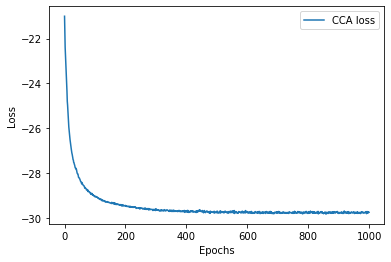

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(model.history.history['cca_loss'], label='CCA loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/cca-loss_model-1.svg', format='svg')

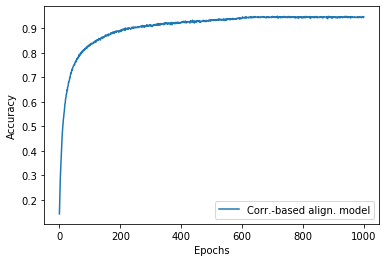

In [37]:
plt.figure()
plt.plot(model.history.history['class_output_acc'], label='Corr.-based align. model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/accuracy_model-1.svg', format='svg')

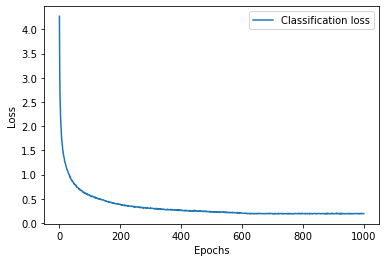

In [38]:
plt.figure()
plt.plot(model.history.history['class_output_loss'], label='Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/classification-loss_model-1.svg', format='svg')

---
---

# Visualization of the Learned Representations

## Joint-representation

In [40]:
inputs = model.model.inputs
class_output = model.model.get_layer('joint_representation').output
base_model = tf.keras.Model(inputs=inputs, outputs=class_output)

In [42]:
codes = base_model.predict(train_dict)

In [43]:
codes.shape

(17058, 120)

In [44]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3).fit_transform(codes)

In [47]:
with open('2021-03-deepCCA-HAR-save/X_embedded_model-1.npy', 'wb') as f:
    np.save(f, X_embedded)

In [ ]:
import plotly.express as px


fig = px.scatter_3d(
    X_embedded, x=0, y=1, z=2,
    color=train_labels,  # labels={'color': 'species'}
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_traces(marker_size=8)
fig.show()

## View-Specific Representation

In [49]:
def get_view(position):
    inputs = [input for input in model.model.inputs if input.name.startswith(position)]
    view = model.model.get_layer('view_'+position).output
    view_model = tf.keras.Model(inputs=inputs, outputs=view)
    
    return view_model

### Bag View

In [50]:
bag = get_view('Bag')

In [52]:
codes = bag.predict(train_dict)

In [53]:
X_embedded = TSNE(n_components=3).fit_transform(codes)

In [54]:
with open('2021-03-deepCCA-HAR-save/X_embedded_Bag-view_model-1.npy', 'wb') as f:
    np.save(f, X_embedded)

### Hand View

In [55]:
hand = get_view('Hand')

In [56]:
codes = hand.predict(train_dict)

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


In [57]:
X_embedded = TSNE(n_components=3).fit_transform(codes)

In [58]:
with open('2021-03-deepCCA-HAR-save/X_embedded_Hand-view_model-1.npy', 'wb') as f:
    np.save(f, X_embedded)

### Hips View

In [59]:
hips = get_view('Hips')

In [60]:
codes = hips.predict(train_dict)

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


In [61]:
X_embedded = TSNE(n_components=3).fit_transform(codes)

In [62]:
with open('2021-03-deepCCA-HAR-save/X_embedded_Hips-view_model-1.npy', 'wb') as f:
    np.save(f, X_embedded)

### Torso View

In [63]:
torso = get_view('Torso')

In [64]:
codes = torso.predict(train_dict)

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


In [65]:
X_embedded = TSNE(n_components=3).fit_transform(codes)

In [66]:
with open('2021-03-deepCCA-HAR-save/X_embedded_Torso-view_model-1.npy', 'wb') as f:
    np.save(f, X_embedded)

---
---

# Predictions

In [89]:
import matplotlib.pyplot as plt
import sklearn.metrics

def plot_confusionMatrix(y_true, y_pred_class):
    confusion_mat = sklearn.metrics.confusion_matrix(y_true, y_pred_class)
    print(confusion_mat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(confusion_mat, cmap=plt.get_cmap().reversed())
    cax = ax.matshow(confusion_mat, cmap='YlGnBu')
    plt.title('Confusion matrix of the base model')
    fig.colorbar(cax)
    #ax.set_xticklabels([''] + labels)
    #ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.show()

## Predictions using the joint-representation

In [84]:
y_pred = model.model.predict(train_dict)
y_pred_class = np.argmax(y_pred[0], axis=1)
y_true = train_labels

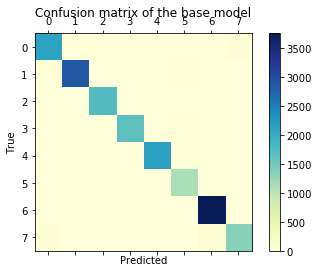

In [90]:
plot_confusionMatrix(y_true, y_pred_class)
plt.savefig('2021-03-deepCCA-HAR-save/confusionMatrix_model-1.svg', format='svg')

## Predictions using view-specific representation

In [147]:
class DiscriminativeView(BaseEstimator):
    def __init__(self, original_model, position, params):
        self.model = self.build_model(original_model, position, params)

    def build_model(self, original_model, position, params):

        xs = []
        inputs = []
        for _, channel in DataReader.channels.items():
            modality = DataReader.channel_to_modality(channel)

            # 3D tensor with shape: (batch_size, steps, input_dim)
            ts = keras.Input(shape=(500,), name=position+'_'+channel)
            x = layers.Reshape((500, 1))(ts)
            # xs.append(x)

            x = layers.Conv1D(
                filters=params[modality]['numfilters']['0'],
                kernel_size=params[modality]['kernelsize']['0'],
                strides=2,
                padding='valid',
                activation='relu',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),
                input_shape=(None, 500, 1),
                name=position+'/'+channel+'/Conv1d/layer_0')(x)
            x = layers.MaxPooling1D()(x)
            x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_0')(x)

            x = layers.Conv1D(
                filters=params[modality]['numfilters']['1'],
                kernel_size=params[modality]['kernelsize']['1'],
                strides=2,
                padding='valid',
                activation='relu',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),
                name=position+'/'+channel+'/Conv1d/layer_1')(x)
            x = layers.MaxPooling1D()(x)
            x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_1')(x)

            x = layers.Conv1D(
                filters=params[modality]['numfilters']['2'],
                kernel_size=params[modality]['kernelsize']['2'],
                strides=2,
                padding='valid',
                activation='relu',
                #kernel_regularizer=regularizers.l2(0.001),
                #bias_regularizer=regularizers.l2(0.001),
                #activity_regularizer=regularizers.l2(0.001),
                name=position+'/'+channel+'/Conv1d/layer_2')(x)
            #---------------------------------
            x = layers.GlobalMaxPooling1D()(x)
            #---------------------------------
            #x = layers.BatchNormalization(name=position+'/'+channel+'/BN/layer_2')(x)

            inputs.append(ts)
            xs.append(x)

        view = keras.layers.concatenate(xs)
        view = layers.Dense(
            params['All']['ccaSpaceDim']['3'],
            activation=None,
            #activation='relu',
            kernel_regularizer=regularizers.l2(0.001),
            bias_regularizer=regularizers.l2(0.001),
            activity_regularizer=regularizers.l2(0.001),
            name='view_'+position)(view)
        base_model = tf.keras.Model(inputs=inputs, outputs=view)

        # assign weights to the new model
        for layer in base_model.layers:
            try:
                weights = original_model.get_layer(layer.name).get_weights()
                base_model.get_layer(layer.name).set_weights(weights)
            except ValueError:
                break
        base_model.trainable = False  #freeze base_model's weights    


        class_outputs = tf.keras.layers.Dense(8, activation='softmax')(view)
        new_model = tf.keras.Model(inputs=inputs, outputs=class_outputs)

        new_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
            loss=[keras.losses.CategoricalCrossentropy(from_logits=True)],
            metrics=['acc'])

        new_model.summary()

        return new_model
    
    def fit(self, X, y):
        self.history = self.model.fit(
            X,
            keras.utils.to_categorical(y, num_classes=len(np.unique(y))),
            batch_size=512,
            epochs=1000,
            shuffle=True,
            #callbacks=[self.lrsched_callback, self.cp_callback]
        )
        return self

### Predictions using Bag view

In [148]:
bag_discriminative = DiscriminativeView(model.model, 'Bag', dict_of_params(params))

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Bag_Pre_m (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
Bag_Acc_m (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
Bag_Gyr_m (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
Bag_Mag_m (InputLayer)          [(None, 500)]        0                                            
___________________________________________________________________________________________

In [149]:
bag_discriminative.fit(train_dict, train_labels)

Epoch 1/1000


/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


34/34 [==============================] - 4s 35ms/step - loss: 288934.3598 - acc: 0.1877
Epoch 2/1000
34/34 [==============================] - 1s 36ms/step - loss: 288936.3196 - acc: 0.1903
Epoch 3/1000
34/34 [==============================] - 1s 36ms/step - loss: 288895.1161 - acc: 0.1797
Epoch 4/1000
34/34 [==============================] - 1s 36ms/step - loss: 288977.2580 - acc: 0.1861
Epoch 5/1000
34/34 [==============================] - 1s 36ms/step - loss: 288924.9607 - acc: 0.1826
Epoch 6/1000
34/34 [==============================] - 1s 36ms/step - loss: 288867.0982 - acc: 0.1809
Epoch 7/1000
34/34 [==============================] - 1s 36ms/step - loss: 288863.2812 - acc: 0.1790
Epoch 8/1000
34/34 [==============================] - 1s 36ms/step - loss: 288933.1000 - acc: 0.1807
Epoch 9/1000
34/34 [==============================] - 1s 36ms/step - loss: 288944.2188 - acc: 0.1830
Epoch 10/1000
34/34 [==============================] - 1s 36ms/step - loss: 288834.0991 - acc: 0.1771
Ep

34/34 [==============================] - 1s 36ms/step - loss: 288791.5723 - acc: 0.2719
Epoch 82/1000
34/34 [==============================] - 1s 36ms/step - loss: 288823.3214 - acc: 0.3047
Epoch 83/1000
34/34 [==============================] - 1s 36ms/step - loss: 288873.1071 - acc: 0.3165
Epoch 84/1000
34/34 [==============================] - 1s 36ms/step - loss: 288846.2732 - acc: 0.3118
Epoch 85/1000
34/34 [==============================] - 1s 36ms/step - loss: 288832.8705 - acc: 0.2919
Epoch 86/1000
34/34 [==============================] - 1s 36ms/step - loss: 288879.6107 - acc: 0.3112
Epoch 87/1000
34/34 [==============================] - 1s 36ms/step - loss: 288863.9589 - acc: 0.3176
Epoch 88/1000
34/34 [==============================] - 1s 36ms/step - loss: 288779.1482 - acc: 0.3473
Epoch 89/1000
34/34 [==============================] - 1s 36ms/step - loss: 288882.6875 - acc: 0.3246
Epoch 90/1000
34/34 [==============================] - 1s 36ms/step - loss: 288853.7589 - acc: 0

34/34 [==============================] - 1s 36ms/step - loss: 288896.0259 - acc: 0.4139
Epoch 161/1000
34/34 [==============================] - 1s 36ms/step - loss: 288923.1384 - acc: 0.4095
Epoch 162/1000
34/34 [==============================] - 1s 36ms/step - loss: 288897.4625 - acc: 0.4101
Epoch 163/1000
34/34 [==============================] - 1s 36ms/step - loss: 288824.7116 - acc: 0.4074
Epoch 164/1000
34/34 [==============================] - 1s 36ms/step - loss: 288855.6554 - acc: 0.4177
Epoch 165/1000
34/34 [==============================] - 1s 36ms/step - loss: 288858.5500 - acc: 0.4097
Epoch 166/1000
34/34 [==============================] - 1s 36ms/step - loss: 288846.1277 - acc: 0.4180
Epoch 167/1000
34/34 [==============================] - 1s 36ms/step - loss: 288765.0312 - acc: 0.4147
Epoch 168/1000
34/34 [==============================] - 1s 36ms/step - loss: 288912.2554 - acc: 0.4189
Epoch 169/1000
34/34 [==============================] - 1s 36ms/step - loss: 288743.9259

34/34 [==============================] - 1s 36ms/step - loss: 288853.8750 - acc: 0.4285
Epoch 240/1000
34/34 [==============================] - 1s 36ms/step - loss: 288850.0768 - acc: 0.4301
Epoch 241/1000
34/34 [==============================] - 1s 36ms/step - loss: 288982.1420 - acc: 0.4305
Epoch 242/1000
34/34 [==============================] - 1s 36ms/step - loss: 288891.8027 - acc: 0.4309
Epoch 243/1000
34/34 [==============================] - 1s 36ms/step - loss: 288806.9241 - acc: 0.4372
Epoch 244/1000
34/34 [==============================] - 1s 36ms/step - loss: 288867.8402 - acc: 0.4291
Epoch 245/1000
34/34 [==============================] - 1s 36ms/step - loss: 288845.9893 - acc: 0.4266
Epoch 246/1000
34/34 [==============================] - 1s 36ms/step - loss: 288917.2786 - acc: 0.4221
Epoch 247/1000
34/34 [==============================] - 1s 36ms/step - loss: 288850.8536 - acc: 0.4310
Epoch 248/1000
34/34 [==============================] - 1s 36ms/step - loss: 288839.2304

34/34 [==============================] - 1s 36ms/step - loss: 288789.0223 - acc: 0.4373
Epoch 319/1000
34/34 [==============================] - 1s 36ms/step - loss: 288810.9500 - acc: 0.4538
Epoch 320/1000
34/34 [==============================] - 1s 36ms/step - loss: 288882.3009 - acc: 0.4472
Epoch 321/1000
34/34 [==============================] - 1s 36ms/step - loss: 288952.1937 - acc: 0.4479
Epoch 322/1000
34/34 [==============================] - 1s 36ms/step - loss: 288791.7696 - acc: 0.4471
Epoch 323/1000
34/34 [==============================] - 1s 36ms/step - loss: 288872.8857 - acc: 0.4469
Epoch 324/1000
34/34 [==============================] - 1s 36ms/step - loss: 288817.4661 - acc: 0.4447
Epoch 325/1000
34/34 [==============================] - 1s 36ms/step - loss: 288810.2893 - acc: 0.4425
Epoch 326/1000
34/34 [==============================] - 1s 36ms/step - loss: 288783.3357 - acc: 0.4431
Epoch 327/1000
34/34 [==============================] - 1s 36ms/step - loss: 288945.7214

34/34 [==============================] - 1s 36ms/step - loss: 288837.7402 - acc: 0.4507
Epoch 398/1000
34/34 [==============================] - 1s 36ms/step - loss: 288780.6286 - acc: 0.4574
Epoch 399/1000
34/34 [==============================] - 1s 36ms/step - loss: 288850.2277 - acc: 0.4594
Epoch 400/1000
34/34 [==============================] - 1s 36ms/step - loss: 288796.1143 - acc: 0.4536
Epoch 401/1000
34/34 [==============================] - 1s 36ms/step - loss: 288854.9188 - acc: 0.4548
Epoch 402/1000
34/34 [==============================] - 1s 36ms/step - loss: 288738.4857 - acc: 0.4530
Epoch 403/1000
34/34 [==============================] - 1s 36ms/step - loss: 288838.0607 - acc: 0.4522
Epoch 404/1000
34/34 [==============================] - 1s 36ms/step - loss: 288869.0687 - acc: 0.4545
Epoch 405/1000
34/34 [==============================] - 1s 36ms/step - loss: 288884.0786 - acc: 0.4530
Epoch 406/1000
34/34 [==============================] - 1s 36ms/step - loss: 288874.0223

34/34 [==============================] - 1s 36ms/step - loss: 288936.5089 - acc: 0.4643
Epoch 477/1000
34/34 [==============================] - 1s 36ms/step - loss: 288809.2795 - acc: 0.4603
Epoch 478/1000
34/34 [==============================] - 1s 36ms/step - loss: 288914.5527 - acc: 0.4688
Epoch 479/1000
34/34 [==============================] - 1s 36ms/step - loss: 288842.8205 - acc: 0.4700
Epoch 480/1000
34/34 [==============================] - 1s 36ms/step - loss: 288873.3634 - acc: 0.4683
Epoch 481/1000
34/34 [==============================] - 1s 36ms/step - loss: 288843.9402 - acc: 0.4715
Epoch 482/1000
34/34 [==============================] - 1s 36ms/step - loss: 288856.4071 - acc: 0.4660
Epoch 483/1000
34/34 [==============================] - 1s 36ms/step - loss: 288843.4527 - acc: 0.4676
Epoch 484/1000
34/34 [==============================] - 1s 36ms/step - loss: 288924.9821 - acc: 0.4727
Epoch 485/1000
34/34 [==============================] - 1s 36ms/step - loss: 288850.1286

34/34 [==============================] - 1s 36ms/step - loss: 288792.7786 - acc: 0.4806
Epoch 556/1000
34/34 [==============================] - 1s 36ms/step - loss: 288901.7393 - acc: 0.4733
Epoch 557/1000
34/34 [==============================] - 1s 36ms/step - loss: 288902.9241 - acc: 0.4772
Epoch 558/1000
34/34 [==============================] - 1s 36ms/step - loss: 288793.0938 - acc: 0.4730
Epoch 559/1000
34/34 [==============================] - 1s 36ms/step - loss: 288738.8187 - acc: 0.4721
Epoch 560/1000
34/34 [==============================] - 1s 36ms/step - loss: 288844.4723 - acc: 0.4755
Epoch 561/1000
34/34 [==============================] - 1s 36ms/step - loss: 288871.1286 - acc: 0.4748
Epoch 562/1000
34/34 [==============================] - 1s 36ms/step - loss: 288898.4741 - acc: 0.4760
Epoch 563/1000
34/34 [==============================] - 1s 36ms/step - loss: 288786.5438 - acc: 0.4703
Epoch 564/1000
34/34 [==============================] - 1s 36ms/step - loss: 288912.4357

34/34 [==============================] - 1s 36ms/step - loss: 288748.0098 - acc: 0.4824
Epoch 635/1000
34/34 [==============================] - 1s 36ms/step - loss: 288849.8902 - acc: 0.4820
Epoch 636/1000
34/34 [==============================] - 1s 36ms/step - loss: 288804.9884 - acc: 0.4798
Epoch 637/1000
34/34 [==============================] - 1s 36ms/step - loss: 288869.3920 - acc: 0.4850
Epoch 638/1000
34/34 [==============================] - 1s 36ms/step - loss: 288876.1920 - acc: 0.4813
Epoch 639/1000
34/34 [==============================] - 1s 36ms/step - loss: 288940.2670 - acc: 0.4781
Epoch 640/1000
34/34 [==============================] - 1s 36ms/step - loss: 288776.8187 - acc: 0.4811
Epoch 641/1000
34/34 [==============================] - 1s 36ms/step - loss: 288843.7348 - acc: 0.4780
Epoch 642/1000
34/34 [==============================] - 1s 36ms/step - loss: 288852.3527 - acc: 0.4740
Epoch 643/1000
34/34 [==============================] - 1s 36ms/step - loss: 288818.5920

34/34 [==============================] - 1s 36ms/step - loss: 288849.0009 - acc: 0.4887
Epoch 714/1000
34/34 [==============================] - 1s 36ms/step - loss: 288898.6929 - acc: 0.4810
Epoch 715/1000
34/34 [==============================] - 1s 36ms/step - loss: 288839.0161 - acc: 0.4873
Epoch 716/1000
34/34 [==============================] - 1s 36ms/step - loss: 288816.4036 - acc: 0.4861
Epoch 717/1000
34/34 [==============================] - 1s 36ms/step - loss: 288895.1554 - acc: 0.4960
Epoch 718/1000
34/34 [==============================] - 1s 36ms/step - loss: 288855.1321 - acc: 0.4830
Epoch 719/1000
34/34 [==============================] - 1s 36ms/step - loss: 288985.7750 - acc: 0.4825
Epoch 720/1000
34/34 [==============================] - 1s 36ms/step - loss: 288848.9643 - acc: 0.4867
Epoch 721/1000
34/34 [==============================] - 1s 36ms/step - loss: 288842.9705 - acc: 0.4883
Epoch 722/1000
34/34 [==============================] - 1s 36ms/step - loss: 288876.3580

34/34 [==============================] - 1s 36ms/step - loss: 288898.3429 - acc: 0.4924
Epoch 793/1000
34/34 [==============================] - 1s 36ms/step - loss: 288784.3098 - acc: 0.4877
Epoch 794/1000
34/34 [==============================] - 1s 36ms/step - loss: 288782.8464 - acc: 0.4959
Epoch 795/1000
34/34 [==============================] - 1s 36ms/step - loss: 288862.1027 - acc: 0.4915
Epoch 796/1000
34/34 [==============================] - 1s 36ms/step - loss: 288854.6196 - acc: 0.4921
Epoch 797/1000
34/34 [==============================] - 1s 36ms/step - loss: 288931.6893 - acc: 0.4801
Epoch 798/1000
34/34 [==============================] - 1s 36ms/step - loss: 288969.7741 - acc: 0.4914
Epoch 799/1000
34/34 [==============================] - 1s 36ms/step - loss: 288785.6054 - acc: 0.4959
Epoch 800/1000
34/34 [==============================] - 1s 36ms/step - loss: 288850.2902 - acc: 0.4956
Epoch 801/1000
34/34 [==============================] - 1s 36ms/step - loss: 288851.7205

34/34 [==============================] - 1s 36ms/step - loss: 288864.4777 - acc: 0.4999
Epoch 872/1000
34/34 [==============================] - 1s 36ms/step - loss: 288873.0134 - acc: 0.4928
Epoch 873/1000
34/34 [==============================] - 1s 36ms/step - loss: 288939.8000 - acc: 0.4959
Epoch 874/1000
34/34 [==============================] - 1s 36ms/step - loss: 288774.1473 - acc: 0.4955
Epoch 875/1000
34/34 [==============================] - 1s 36ms/step - loss: 288855.7884 - acc: 0.4949
Epoch 876/1000
34/34 [==============================] - 1s 36ms/step - loss: 288854.5491 - acc: 0.4973
Epoch 877/1000
34/34 [==============================] - 1s 36ms/step - loss: 288843.4616 - acc: 0.4884
Epoch 878/1000
34/34 [==============================] - 1s 36ms/step - loss: 288821.6134 - acc: 0.4923
Epoch 879/1000
34/34 [==============================] - 1s 36ms/step - loss: 288842.6018 - acc: 0.4989
Epoch 880/1000
34/34 [==============================] - 1s 36ms/step - loss: 288793.4000

34/34 [==============================] - 1s 36ms/step - loss: 288829.6955 - acc: 0.5052
Epoch 951/1000
34/34 [==============================] - 1s 36ms/step - loss: 288903.7107 - acc: 0.5033
Epoch 952/1000
34/34 [==============================] - 1s 36ms/step - loss: 288847.7045 - acc: 0.5102
Epoch 953/1000
34/34 [==============================] - 1s 36ms/step - loss: 288811.3080 - acc: 0.4904
Epoch 954/1000
34/34 [==============================] - 1s 36ms/step - loss: 288775.4429 - acc: 0.5013
Epoch 955/1000
34/34 [==============================] - 1s 36ms/step - loss: 288798.6866 - acc: 0.4985
Epoch 956/1000
34/34 [==============================] - 1s 36ms/step - loss: 288942.2321 - acc: 0.4998
Epoch 957/1000
34/34 [==============================] - 1s 36ms/step - loss: 288874.4411 - acc: 0.5019
Epoch 958/1000
34/34 [==============================] - 1s 36ms/step - loss: 288867.3446 - acc: 0.4986
Epoch 959/1000
34/34 [==============================] - 1s 36ms/step - loss: 288872.0607

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


DiscriminativeView(original_model=None, params=None, position=None)

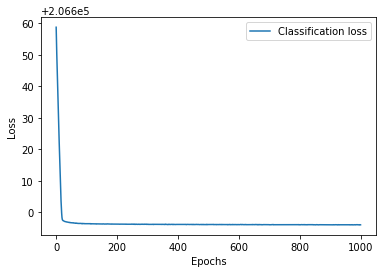

In [129]:
plt.figure()
plt.plot(bag_discriminative.history.history['loss'], label='Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/classification-loss_Bag_DiscriminativeModel.svg', format='svg')

In [126]:
y_pred = bag_discriminative.model.predict(train_dict)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = train_labels

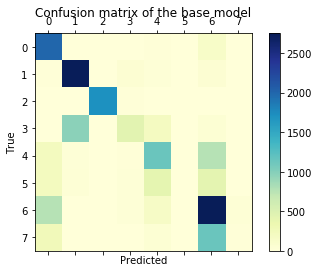

In [128]:
plot_confusionMatrix(y_true, y_pred_class)
plt.savefig('2021-03-deepCCA-HAR-save/confusionMatrix_Bag_DiscriminativeModel.svg')

### Predictions using Hand view

In [130]:
hand_discriminative = DiscriminativeView(model.model, 'Hand', dict_of_params(params))

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hand_Pre_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hand_Acc_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hand_Gyr_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hand_Mag_m (InputLayer)         [(None, 500)]        0                                            
___________________________________________________________________________________________

In [131]:
hand_discriminative.fit(train_dict, train_labels)

Epoch 1/1000


/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


34/34 [==============================] - 4s 35ms/step - loss: 287849.9071 - acc: 0.0745
Epoch 2/1000
34/34 [==============================] - 1s 36ms/step - loss: 287813.2179 - acc: 0.0750
Epoch 3/1000
34/34 [==============================] - 1s 35ms/step - loss: 287789.1795 - acc: 0.0731
Epoch 4/1000
34/34 [==============================] - 1s 36ms/step - loss: 287861.8179 - acc: 0.0706
Epoch 5/1000
34/34 [==============================] - 1s 36ms/step - loss: 287782.8714 - acc: 0.0706
Epoch 6/1000
34/34 [==============================] - 1s 35ms/step - loss: 287735.9321 - acc: 0.0729
Epoch 7/1000
34/34 [==============================] - 1s 36ms/step - loss: 287759.7375 - acc: 0.0735
Epoch 8/1000
34/34 [==============================] - 1s 35ms/step - loss: 287770.6455 - acc: 0.0730
Epoch 9/1000
34/34 [==============================] - 1s 35ms/step - loss: 287813.5134 - acc: 0.0791
Epoch 10/1000
34/34 [==============================] - 1s 36ms/step - loss: 287716.7250 - acc: 0.1006
Ep

34/34 [==============================] - 1s 36ms/step - loss: 287689.3946 - acc: 0.5024
Epoch 82/1000
34/34 [==============================] - 1s 36ms/step - loss: 287698.9161 - acc: 0.5015
Epoch 83/1000
34/34 [==============================] - 1s 36ms/step - loss: 287723.1571 - acc: 0.5058
Epoch 84/1000
34/34 [==============================] - 1s 36ms/step - loss: 287716.9661 - acc: 0.5040
Epoch 85/1000
34/34 [==============================] - 1s 36ms/step - loss: 287681.9536 - acc: 0.5070
Epoch 86/1000
34/34 [==============================] - 1s 36ms/step - loss: 287748.6777 - acc: 0.5098
Epoch 87/1000
34/34 [==============================] - 1s 36ms/step - loss: 287665.7634 - acc: 0.5071
Epoch 88/1000
34/34 [==============================] - 1s 36ms/step - loss: 287667.8830 - acc: 0.5102
Epoch 89/1000
34/34 [==============================] - 1s 36ms/step - loss: 287692.6268 - acc: 0.5114
Epoch 90/1000
34/34 [==============================] - 1s 35ms/step - loss: 287766.1321 - acc: 0

34/34 [==============================] - 1s 35ms/step - loss: 287752.7589 - acc: 0.5705
Epoch 161/1000
34/34 [==============================] - 1s 35ms/step - loss: 287770.1402 - acc: 0.5566
Epoch 162/1000
34/34 [==============================] - 1s 35ms/step - loss: 287764.2848 - acc: 0.5539
Epoch 163/1000
34/34 [==============================] - 1s 36ms/step - loss: 287714.1804 - acc: 0.5639
Epoch 164/1000
34/34 [==============================] - 1s 36ms/step - loss: 287716.7938 - acc: 0.5583
Epoch 165/1000
34/34 [==============================] - 1s 35ms/step - loss: 287768.1821 - acc: 0.5648
Epoch 166/1000
34/34 [==============================] - 1s 36ms/step - loss: 287727.7902 - acc: 0.5626
Epoch 167/1000
34/34 [==============================] - 1s 35ms/step - loss: 287656.9786 - acc: 0.5665
Epoch 168/1000
34/34 [==============================] - 1s 36ms/step - loss: 287771.0670 - acc: 0.5569
Epoch 169/1000
34/34 [==============================] - 1s 36ms/step - loss: 287621.6955

34/34 [==============================] - 1s 35ms/step - loss: 287729.9348 - acc: 0.5862
Epoch 240/1000
34/34 [==============================] - 1s 35ms/step - loss: 287682.1143 - acc: 0.5903
Epoch 241/1000
34/34 [==============================] - 1s 36ms/step - loss: 287834.0491 - acc: 0.5917
Epoch 242/1000
34/34 [==============================] - 1s 36ms/step - loss: 287739.8161 - acc: 0.5889
Epoch 243/1000
34/34 [==============================] - 1s 35ms/step - loss: 287696.7830 - acc: 0.6006
Epoch 244/1000
34/34 [==============================] - 1s 36ms/step - loss: 287744.9473 - acc: 0.5901
Epoch 245/1000
34/34 [==============================] - 1s 36ms/step - loss: 287731.9304 - acc: 0.5894
Epoch 246/1000
34/34 [==============================] - 1s 35ms/step - loss: 287749.6786 - acc: 0.5903
Epoch 247/1000
34/34 [==============================] - 1s 36ms/step - loss: 287714.7750 - acc: 0.5910
Epoch 248/1000
34/34 [==============================] - 1s 35ms/step - loss: 287727.0223

34/34 [==============================] - 1s 35ms/step - loss: 287685.5411 - acc: 0.6042
Epoch 319/1000
34/34 [==============================] - 1s 35ms/step - loss: 287703.9973 - acc: 0.6042
Epoch 320/1000
34/34 [==============================] - 1s 35ms/step - loss: 287765.0545 - acc: 0.6098
Epoch 321/1000
34/34 [==============================] - 1s 35ms/step - loss: 287800.9268 - acc: 0.6096
Epoch 322/1000
34/34 [==============================] - 1s 35ms/step - loss: 287667.0777 - acc: 0.6037
Epoch 323/1000
34/34 [==============================] - 1s 35ms/step - loss: 287722.2964 - acc: 0.6033
Epoch 324/1000
34/34 [==============================] - 1s 35ms/step - loss: 287679.8634 - acc: 0.6007
Epoch 325/1000
34/34 [==============================] - 1s 35ms/step - loss: 287686.0938 - acc: 0.6011
Epoch 326/1000
34/34 [==============================] - 1s 35ms/step - loss: 287687.4411 - acc: 0.5996
Epoch 327/1000
34/34 [==============================] - 1s 35ms/step - loss: 287781.4000

34/34 [==============================] - 1s 36ms/step - loss: 287750.8196 - acc: 0.6129
Epoch 398/1000
34/34 [==============================] - 1s 36ms/step - loss: 287692.0339 - acc: 0.6183
Epoch 399/1000
34/34 [==============================] - 1s 36ms/step - loss: 287728.3098 - acc: 0.6144
Epoch 400/1000
34/34 [==============================] - 1s 36ms/step - loss: 287690.6857 - acc: 0.6157
Epoch 401/1000
34/34 [==============================] - 1s 36ms/step - loss: 287780.1634 - acc: 0.6104
Epoch 402/1000
34/34 [==============================] - 1s 36ms/step - loss: 287620.2188 - acc: 0.6061
Epoch 403/1000
34/34 [==============================] - 1s 36ms/step - loss: 287712.0500 - acc: 0.6117
Epoch 404/1000
34/34 [==============================] - 1s 36ms/step - loss: 287760.2464 - acc: 0.6087
Epoch 405/1000
34/34 [==============================] - 1s 36ms/step - loss: 287803.1786 - acc: 0.6088
Epoch 406/1000
34/34 [==============================] - 1s 36ms/step - loss: 287752.3268

34/34 [==============================] - 1s 36ms/step - loss: 287849.1036 - acc: 0.6217
Epoch 477/1000
34/34 [==============================] - 1s 36ms/step - loss: 287701.7812 - acc: 0.6136
Epoch 478/1000
34/34 [==============================] - 1s 36ms/step - loss: 287797.1196 - acc: 0.6195
Epoch 479/1000
34/34 [==============================] - 1s 36ms/step - loss: 287709.8688 - acc: 0.6132
Epoch 480/1000
34/34 [==============================] - 1s 35ms/step - loss: 287737.2741 - acc: 0.6166
Epoch 481/1000
34/34 [==============================] - 1s 36ms/step - loss: 287691.3089 - acc: 0.6179
Epoch 482/1000
34/34 [==============================] - 1s 36ms/step - loss: 287701.5187 - acc: 0.6156
Epoch 483/1000
34/34 [==============================] - 1s 35ms/step - loss: 287721.4688 - acc: 0.6179
Epoch 484/1000
34/34 [==============================] - 1s 36ms/step - loss: 287810.4009 - acc: 0.6260
Epoch 485/1000
34/34 [==============================] - 1s 36ms/step - loss: 287738.2268

34/34 [==============================] - 1s 36ms/step - loss: 287697.6268 - acc: 0.6207
Epoch 556/1000
34/34 [==============================] - 1s 36ms/step - loss: 287747.5295 - acc: 0.6208
Epoch 557/1000
34/34 [==============================] - 1s 36ms/step - loss: 287783.9643 - acc: 0.6202
Epoch 558/1000
34/34 [==============================] - 1s 36ms/step - loss: 287675.9027 - acc: 0.6239
Epoch 559/1000
34/34 [==============================] - 1s 36ms/step - loss: 287624.9777 - acc: 0.6252
Epoch 560/1000
34/34 [==============================] - 1s 35ms/step - loss: 287725.8205 - acc: 0.6270
Epoch 561/1000
34/34 [==============================] - 1s 35ms/step - loss: 287762.7018 - acc: 0.6185
Epoch 562/1000
34/34 [==============================] - 1s 35ms/step - loss: 287705.6973 - acc: 0.6251
Epoch 563/1000
34/34 [==============================] - 1s 35ms/step - loss: 287687.4241 - acc: 0.6200
Epoch 564/1000
34/34 [==============================] - 1s 36ms/step - loss: 287767.2768

34/34 [==============================] - 1s 36ms/step - loss: 287646.7518 - acc: 0.6262
Epoch 635/1000
34/34 [==============================] - 1s 35ms/step - loss: 287711.4473 - acc: 0.6253
Epoch 636/1000
34/34 [==============================] - 1s 35ms/step - loss: 287660.0554 - acc: 0.6257
Epoch 637/1000
34/34 [==============================] - 1s 35ms/step - loss: 287711.9062 - acc: 0.6247
Epoch 638/1000
34/34 [==============================] - 1s 36ms/step - loss: 287678.2679 - acc: 0.6229
Epoch 639/1000
34/34 [==============================] - 1s 36ms/step - loss: 287831.3554 - acc: 0.6229
Epoch 640/1000
34/34 [==============================] - 1s 35ms/step - loss: 287635.6464 - acc: 0.6264
Epoch 641/1000
34/34 [==============================] - 1s 35ms/step - loss: 287725.3902 - acc: 0.6271
Epoch 642/1000
34/34 [==============================] - 1s 36ms/step - loss: 287718.4304 - acc: 0.6227
Epoch 643/1000
34/34 [==============================] - 1s 35ms/step - loss: 287719.2482

34/34 [==============================] - 1s 35ms/step - loss: 287726.4571 - acc: 0.6327
Epoch 714/1000
34/34 [==============================] - 1s 35ms/step - loss: 287770.2652 - acc: 0.6261
Epoch 715/1000
34/34 [==============================] - 1s 36ms/step - loss: 287698.5893 - acc: 0.6222
Epoch 716/1000
34/34 [==============================] - 1s 36ms/step - loss: 287720.1607 - acc: 0.6347
Epoch 717/1000
34/34 [==============================] - 1s 36ms/step - loss: 287766.2295 - acc: 0.6249
Epoch 718/1000
34/34 [==============================] - 1s 36ms/step - loss: 287755.2420 - acc: 0.6303
Epoch 719/1000
34/34 [==============================] - 1s 36ms/step - loss: 287844.0170 - acc: 0.6298
Epoch 720/1000
34/34 [==============================] - 1s 35ms/step - loss: 287729.9554 - acc: 0.6260
Epoch 721/1000
34/34 [==============================] - 1s 35ms/step - loss: 287731.9116 - acc: 0.6227
Epoch 722/1000
34/34 [==============================] - 1s 36ms/step - loss: 287758.5286

34/34 [==============================] - 1s 36ms/step - loss: 287763.5545 - acc: 0.6356
Epoch 793/1000
34/34 [==============================] - 1s 35ms/step - loss: 287659.9223 - acc: 0.6253
Epoch 794/1000
34/34 [==============================] - 1s 35ms/step - loss: 287653.9750 - acc: 0.6345
Epoch 795/1000
34/34 [==============================] - 1s 35ms/step - loss: 287740.1598 - acc: 0.6274
Epoch 796/1000
34/34 [==============================] - 1s 36ms/step - loss: 287725.3179 - acc: 0.6304
Epoch 797/1000
34/34 [==============================] - 1s 36ms/step - loss: 287803.5045 - acc: 0.6338
Epoch 798/1000
34/34 [==============================] - 1s 36ms/step - loss: 287829.3920 - acc: 0.6334
Epoch 799/1000
34/34 [==============================] - 1s 36ms/step - loss: 287647.6554 - acc: 0.6355
Epoch 800/1000
34/34 [==============================] - 1s 36ms/step - loss: 287730.0509 - acc: 0.6327
Epoch 801/1000
34/34 [==============================] - 1s 36ms/step - loss: 287728.8759

34/34 [==============================] - 1s 35ms/step - loss: 287733.8661 - acc: 0.6341
Epoch 872/1000
34/34 [==============================] - 1s 35ms/step - loss: 287731.3143 - acc: 0.6374
Epoch 873/1000
34/34 [==============================] - 1s 35ms/step - loss: 287769.9679 - acc: 0.6413
Epoch 874/1000
34/34 [==============================] - 1s 35ms/step - loss: 287654.5946 - acc: 0.6355
Epoch 875/1000
34/34 [==============================] - 1s 35ms/step - loss: 287740.3063 - acc: 0.6336
Epoch 876/1000
34/34 [==============================] - 1s 36ms/step - loss: 287697.2339 - acc: 0.6374
Epoch 877/1000
34/34 [==============================] - 1s 36ms/step - loss: 287755.9188 - acc: 0.6285
Epoch 878/1000
34/34 [==============================] - 1s 36ms/step - loss: 287700.6714 - acc: 0.6361
Epoch 879/1000
34/34 [==============================] - 1s 36ms/step - loss: 287729.5991 - acc: 0.6406
Epoch 880/1000
34/34 [==============================] - 1s 35ms/step - loss: 287673.3321

34/34 [==============================] - 1s 35ms/step - loss: 287709.0893 - acc: 0.6382
Epoch 951/1000
34/34 [==============================] - 1s 35ms/step - loss: 287744.4821 - acc: 0.6352
Epoch 952/1000
34/34 [==============================] - 1s 35ms/step - loss: 287768.7804 - acc: 0.6412
Epoch 953/1000
34/34 [==============================] - 1s 35ms/step - loss: 287689.2839 - acc: 0.6369
Epoch 954/1000
34/34 [==============================] - 1s 35ms/step - loss: 287620.7938 - acc: 0.6393
Epoch 955/1000
34/34 [==============================] - 1s 35ms/step - loss: 287659.2857 - acc: 0.6360
Epoch 956/1000
34/34 [==============================] - 1s 36ms/step - loss: 287825.1643 - acc: 0.6343
Epoch 957/1000
34/34 [==============================] - 1s 36ms/step - loss: 287751.5375 - acc: 0.6423
Epoch 958/1000
34/34 [==============================] - 1s 35ms/step - loss: 287730.1768 - acc: 0.6423
Epoch 959/1000
34/34 [==============================] - 1s 35ms/step - loss: 287725.9634

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


DiscriminativeView(original_model=None, params=None, position=None)

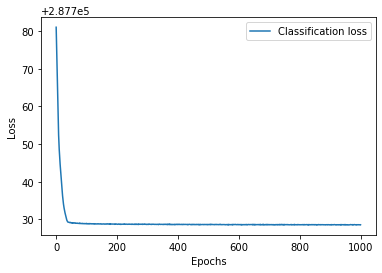

In [133]:
plt.figure()
plt.plot(hand_discriminative.history.history['loss'], label='Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/classification-loss_Hand_DiscriminativeModel.svg', format='svg')

In [134]:
y_pred = hand_discriminative.model.predict(train_dict)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = train_labels

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


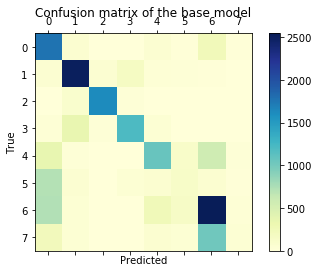

In [135]:
plot_confusionMatrix(y_true, y_pred_class)
plt.savefig('2021-03-deepCCA-HAR-save/confusionMatrix_Hand_DiscriminativeModel.svg')

### Predictions using Hips view

In [136]:
hips_discriminative = DiscriminativeView(model.model, 'Hips', dict_of_params(params))

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hips_Pre_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hips_Acc_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hips_Gyr_m (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Hips_Mag_m (InputLayer)         [(None, 500)]        0                                            
___________________________________________________________________________________________

In [138]:
hips_discriminative.fit(train_dict, train_labels)

Epoch 1/1000


/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


34/34 [==============================] - 4s 35ms/step - loss: 216599.1326 - acc: 0.1010
Epoch 2/1000
34/34 [==============================] - 1s 35ms/step - loss: 216584.5509 - acc: 0.0959
Epoch 3/1000
34/34 [==============================] - 1s 35ms/step - loss: 216554.5027 - acc: 0.0998
Epoch 4/1000
34/34 [==============================] - 1s 35ms/step - loss: 216616.5545 - acc: 0.1039
Epoch 5/1000
34/34 [==============================] - 1s 35ms/step - loss: 216543.4362 - acc: 0.0981
Epoch 6/1000
34/34 [==============================] - 1s 35ms/step - loss: 216513.9406 - acc: 0.0953
Epoch 7/1000
34/34 [==============================] - 1s 35ms/step - loss: 216518.7250 - acc: 0.1135
Epoch 8/1000
34/34 [==============================] - 1s 35ms/step - loss: 216542.3723 - acc: 0.1195
Epoch 9/1000
34/34 [==============================] - 1s 35ms/step - loss: 216547.0442 - acc: 0.1203
Epoch 10/1000
34/34 [==============================] - 1s 35ms/step - loss: 216481.9165 - acc: 0.2117
Ep

34/34 [==============================] - 1s 35ms/step - loss: 216421.9504 - acc: 0.5197
Epoch 82/1000
34/34 [==============================] - 1s 35ms/step - loss: 216441.6375 - acc: 0.5205
Epoch 83/1000
34/34 [==============================] - 1s 35ms/step - loss: 216472.2478 - acc: 0.5268
Epoch 84/1000
34/34 [==============================] - 1s 35ms/step - loss: 216468.4156 - acc: 0.5188
Epoch 85/1000
34/34 [==============================] - 1s 35ms/step - loss: 216439.4888 - acc: 0.5191
Epoch 86/1000
34/34 [==============================] - 1s 35ms/step - loss: 216492.5871 - acc: 0.5263
Epoch 87/1000
34/34 [==============================] - 1s 35ms/step - loss: 216434.8326 - acc: 0.5239
Epoch 88/1000
34/34 [==============================] - 1s 35ms/step - loss: 216419.5317 - acc: 0.5208
Epoch 89/1000
34/34 [==============================] - 1s 35ms/step - loss: 216435.4536 - acc: 0.5220
Epoch 90/1000
34/34 [==============================] - 1s 35ms/step - loss: 216487.0991 - acc: 0

34/34 [==============================] - 1s 35ms/step - loss: 216490.6504 - acc: 0.5336
Epoch 161/1000
34/34 [==============================] - 1s 35ms/step - loss: 216488.4723 - acc: 0.5317
Epoch 162/1000
34/34 [==============================] - 1s 35ms/step - loss: 216504.8612 - acc: 0.5364
Epoch 163/1000
34/34 [==============================] - 1s 35ms/step - loss: 216466.3848 - acc: 0.5325
Epoch 164/1000
34/34 [==============================] - 1s 35ms/step - loss: 216472.8161 - acc: 0.5309
Epoch 165/1000
34/34 [==============================] - 1s 35ms/step - loss: 216484.2071 - acc: 0.5377
Epoch 166/1000
34/34 [==============================] - 1s 35ms/step - loss: 216481.2254 - acc: 0.5333
Epoch 167/1000
34/34 [==============================] - 1s 35ms/step - loss: 216416.8978 - acc: 0.5325
Epoch 168/1000
34/34 [==============================] - 1s 35ms/step - loss: 216484.7612 - acc: 0.5403
Epoch 169/1000
34/34 [==============================] - 1s 35ms/step - loss: 216405.3254

34/34 [==============================] - 1s 35ms/step - loss: 216466.9955 - acc: 0.5450
Epoch 240/1000
34/34 [==============================] - 1s 35ms/step - loss: 216459.0080 - acc: 0.5547
Epoch 241/1000
34/34 [==============================] - 1s 35ms/step - loss: 216552.1598 - acc: 0.5448
Epoch 242/1000
34/34 [==============================] - 1s 35ms/step - loss: 216484.1929 - acc: 0.5486
Epoch 243/1000
34/34 [==============================] - 1s 35ms/step - loss: 216441.4152 - acc: 0.5520
Epoch 244/1000
34/34 [==============================] - 1s 35ms/step - loss: 216494.8482 - acc: 0.5558
Epoch 245/1000
34/34 [==============================] - 1s 35ms/step - loss: 216478.4433 - acc: 0.5439
Epoch 246/1000
34/34 [==============================] - 1s 35ms/step - loss: 216504.9879 - acc: 0.5497
Epoch 247/1000
34/34 [==============================] - 1s 35ms/step - loss: 216449.5312 - acc: 0.5511
Epoch 248/1000
34/34 [==============================] - 1s 35ms/step - loss: 216464.8174

34/34 [==============================] - 1s 35ms/step - loss: 216427.9089 - acc: 0.5556
Epoch 319/1000
34/34 [==============================] - 1s 35ms/step - loss: 216452.2969 - acc: 0.5615
Epoch 320/1000
34/34 [==============================] - 1s 35ms/step - loss: 216482.9813 - acc: 0.5549
Epoch 321/1000
34/34 [==============================] - 1s 35ms/step - loss: 216511.1982 - acc: 0.5519
Epoch 322/1000
34/34 [==============================] - 1s 35ms/step - loss: 216444.8772 - acc: 0.5571
Epoch 323/1000
34/34 [==============================] - 1s 35ms/step - loss: 216469.8036 - acc: 0.5602
Epoch 324/1000
34/34 [==============================] - 1s 35ms/step - loss: 216451.7879 - acc: 0.5533
Epoch 325/1000
34/34 [==============================] - 1s 35ms/step - loss: 216437.5219 - acc: 0.5567
Epoch 326/1000
34/34 [==============================] - 1s 35ms/step - loss: 216435.9696 - acc: 0.5585
Epoch 327/1000
34/34 [==============================] - 1s 35ms/step - loss: 216521.3143

34/34 [==============================] - 1s 35ms/step - loss: 216468.7129 - acc: 0.5676
Epoch 398/1000
34/34 [==============================] - 1s 35ms/step - loss: 216424.7442 - acc: 0.5606
Epoch 399/1000
34/34 [==============================] - 1s 35ms/step - loss: 216460.8170 - acc: 0.5638
Epoch 400/1000
34/34 [==============================] - 1s 35ms/step - loss: 216449.1112 - acc: 0.5570
Epoch 401/1000
34/34 [==============================] - 1s 35ms/step - loss: 216478.6487 - acc: 0.5651
Epoch 402/1000
34/34 [==============================] - 1s 36ms/step - loss: 216399.0487 - acc: 0.5643
Epoch 403/1000
34/34 [==============================] - 1s 36ms/step - loss: 216455.4670 - acc: 0.5700
Epoch 404/1000
34/34 [==============================] - 1s 35ms/step - loss: 216496.0982 - acc: 0.5639
Epoch 405/1000
34/34 [==============================] - 1s 35ms/step - loss: 216510.4911 - acc: 0.5706
Epoch 406/1000
34/34 [==============================] - 1s 36ms/step - loss: 216488.8429

34/34 [==============================] - 1s 35ms/step - loss: 216545.6357 - acc: 0.5719
Epoch 477/1000
34/34 [==============================] - 1s 35ms/step - loss: 216434.7531 - acc: 0.5757
Epoch 478/1000
34/34 [==============================] - 1s 35ms/step - loss: 216520.5080 - acc: 0.5774
Epoch 479/1000
34/34 [==============================] - 1s 35ms/step - loss: 216440.3049 - acc: 0.5752
Epoch 480/1000
34/34 [==============================] - 1s 35ms/step - loss: 216463.8897 - acc: 0.5729
Epoch 481/1000
34/34 [==============================] - 1s 35ms/step - loss: 216448.3625 - acc: 0.5633
Epoch 482/1000
34/34 [==============================] - 1s 35ms/step - loss: 216453.3911 - acc: 0.5834
Epoch 483/1000
34/34 [==============================] - 1s 35ms/step - loss: 216467.9246 - acc: 0.5741
Epoch 484/1000
34/34 [==============================] - 1s 35ms/step - loss: 216535.0616 - acc: 0.5821
Epoch 485/1000
34/34 [==============================] - 1s 35ms/step - loss: 216484.1045

34/34 [==============================] - 1s 35ms/step - loss: 216441.3973 - acc: 0.5855
Epoch 556/1000
34/34 [==============================] - 1s 35ms/step - loss: 216462.9879 - acc: 0.5863
Epoch 557/1000
34/34 [==============================] - 1s 35ms/step - loss: 216514.5942 - acc: 0.5836
Epoch 558/1000
34/34 [==============================] - 1s 35ms/step - loss: 216437.5554 - acc: 0.6244
Epoch 559/1000
34/34 [==============================] - 1s 35ms/step - loss: 216401.3304 - acc: 0.5978
Epoch 560/1000
34/34 [==============================] - 1s 35ms/step - loss: 216477.1915 - acc: 0.5737
Epoch 561/1000
34/34 [==============================] - 1s 35ms/step - loss: 216498.5214 - acc: 0.6155
Epoch 562/1000
34/34 [==============================] - 1s 35ms/step - loss: 216446.8951 - acc: 0.5830
Epoch 563/1000
34/34 [==============================] - 1s 35ms/step - loss: 216443.1313 - acc: 0.5899
Epoch 564/1000
34/34 [==============================] - 1s 35ms/step - loss: 216516.1754

34/34 [==============================] - 1s 35ms/step - loss: 216402.4513 - acc: 0.5922
Epoch 635/1000
34/34 [==============================] - 1s 35ms/step - loss: 216472.8464 - acc: 0.6347
Epoch 636/1000
34/34 [==============================] - 1s 35ms/step - loss: 216444.3473 - acc: 0.5951
Epoch 637/1000
34/34 [==============================] - 1s 35ms/step - loss: 216476.2000 - acc: 0.6201
Epoch 638/1000
34/34 [==============================] - 1s 35ms/step - loss: 216436.4656 - acc: 0.6333
Epoch 639/1000
34/34 [==============================] - 1s 35ms/step - loss: 216539.2089 - acc: 0.6068
Epoch 640/1000
34/34 [==============================] - 1s 35ms/step - loss: 216403.7746 - acc: 0.6018
Epoch 641/1000
34/34 [==============================] - 1s 36ms/step - loss: 216467.5446 - acc: 0.6320
Epoch 642/1000
34/34 [==============================] - 1s 36ms/step - loss: 216471.7812 - acc: 0.6092
Epoch 643/1000
34/34 [==============================] - 1s 35ms/step - loss: 216455.5121

34/34 [==============================] - 1s 35ms/step - loss: 216448.5924 - acc: 0.6002
Epoch 714/1000
34/34 [==============================] - 1s 35ms/step - loss: 216486.6817 - acc: 0.6041
Epoch 715/1000
34/34 [==============================] - 1s 35ms/step - loss: 216466.1411 - acc: 0.6496
Epoch 716/1000
34/34 [==============================] - 1s 35ms/step - loss: 216452.6616 - acc: 0.6195
Epoch 717/1000
34/34 [==============================] - 1s 35ms/step - loss: 216495.4277 - acc: 0.6240
Epoch 718/1000
34/34 [==============================] - 1s 35ms/step - loss: 216487.2728 - acc: 0.6005
Epoch 719/1000
34/34 [==============================] - 1s 35ms/step - loss: 216552.6464 - acc: 0.6176
Epoch 720/1000
34/34 [==============================] - 1s 35ms/step - loss: 216481.5214 - acc: 0.6156
Epoch 721/1000
34/34 [==============================] - 1s 35ms/step - loss: 216476.7232 - acc: 0.6359
Epoch 722/1000
34/34 [==============================] - 1s 35ms/step - loss: 216496.0812

34/34 [==============================] - 1s 35ms/step - loss: 216512.2357 - acc: 0.6473
Epoch 793/1000
34/34 [==============================] - 1s 35ms/step - loss: 216433.0464 - acc: 0.6413
Epoch 794/1000
34/34 [==============================] - 1s 35ms/step - loss: 216423.1259 - acc: 0.6276
Epoch 795/1000
34/34 [==============================] - 1s 35ms/step - loss: 216478.4348 - acc: 0.6226
Epoch 796/1000
34/34 [==============================] - 1s 35ms/step - loss: 216471.4982 - acc: 0.6259
Epoch 797/1000
34/34 [==============================] - 1s 35ms/step - loss: 216525.1366 - acc: 0.6464
Epoch 798/1000
34/34 [==============================] - 1s 35ms/step - loss: 216543.0594 - acc: 0.6073
Epoch 799/1000
34/34 [==============================] - 1s 35ms/step - loss: 216425.8679 - acc: 0.6500
Epoch 800/1000
34/34 [==============================] - 1s 35ms/step - loss: 216459.7634 - acc: 0.6120
Epoch 801/1000
34/34 [==============================] - 1s 35ms/step - loss: 216458.7116

34/34 [==============================] - 1s 35ms/step - loss: 216467.9263 - acc: 0.6555
Epoch 872/1000
34/34 [==============================] - 1s 35ms/step - loss: 216481.5384 - acc: 0.6283
Epoch 873/1000
34/34 [==============================] - 1s 35ms/step - loss: 216503.4429 - acc: 0.6446
Epoch 874/1000
34/34 [==============================] - 1s 35ms/step - loss: 216422.0754 - acc: 0.6470
Epoch 875/1000
34/34 [==============================] - 1s 35ms/step - loss: 216481.7942 - acc: 0.6406
Epoch 876/1000
34/34 [==============================] - 1s 35ms/step - loss: 216454.3165 - acc: 0.6272
Epoch 877/1000
34/34 [==============================] - 1s 35ms/step - loss: 216485.0491 - acc: 0.6499
Epoch 878/1000
34/34 [==============================] - 1s 35ms/step - loss: 216437.4589 - acc: 0.6523
Epoch 879/1000
34/34 [==============================] - 1s 35ms/step - loss: 216483.0371 - acc: 0.6377
Epoch 880/1000
34/34 [==============================] - 1s 35ms/step - loss: 216425.8638

34/34 [==============================] - 1s 35ms/step - loss: 216466.4420 - acc: 0.6553
Epoch 951/1000
34/34 [==============================] - 1s 36ms/step - loss: 216476.4853 - acc: 0.6406
Epoch 952/1000
34/34 [==============================] - 1s 36ms/step - loss: 216461.8679 - acc: 0.6457
Epoch 953/1000
34/34 [==============================] - 1s 35ms/step - loss: 216445.7987 - acc: 0.6487
Epoch 954/1000
34/34 [==============================] - 1s 35ms/step - loss: 216400.7339 - acc: 0.6575
Epoch 955/1000
34/34 [==============================] - 1s 35ms/step - loss: 216431.5098 - acc: 0.6302
Epoch 956/1000
34/34 [==============================] - 1s 35ms/step - loss: 216546.7790 - acc: 0.6381
Epoch 957/1000
34/34 [==============================] - 1s 35ms/step - loss: 216487.5576 - acc: 0.6615
Epoch 958/1000
34/34 [==============================] - 1s 35ms/step - loss: 216469.0272 - acc: 0.6120
Epoch 959/1000
34/34 [==============================] - 1s 35ms/step - loss: 216483.2272

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


DiscriminativeView(original_model=None, params=None, position=None)

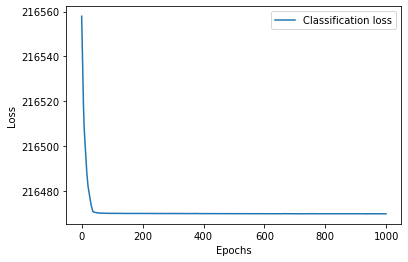

In [139]:
plt.figure()
plt.plot(hips_discriminative.history.history['loss'], label='Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/classification-loss_Hips_DiscriminativeModel.svg', format='svg')

In [140]:
y_pred = hips_discriminative.model.predict(train_dict)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = train_labels

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Torso_Pre_m', 'Torso_Acc_m', 'Torso_Gyr_m', 'Torso_Mag_m', 'Torso_Ori_m', 'Torso_Gra_m', 'Torso_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


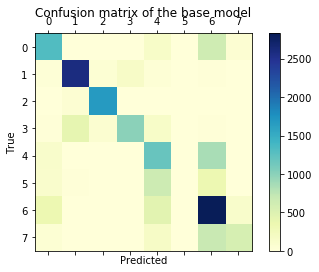

In [141]:
plot_confusionMatrix(y_true, y_pred_class)
plt.savefig('2021-03-deepCCA-HAR-save/confusionMatrix_Hips_DiscriminativeModel.svg')

### Predictions using Torso views

In [142]:
torso_discriminative = DiscriminativeView(model.model, 'Torso', dict_of_params(params))

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Torso_Pre_m (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
Torso_Acc_m (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
Torso_Gyr_m (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
Torso_Mag_m (InputLayer)        [(None, 500)]        0                                            
___________________________________________________________________________________________

In [143]:
torso_discriminative.fit(train_dict, train_labels)

Epoch 1/1000


/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


34/34 [==============================] - 4s 35ms/step - loss: 439890.0920 - acc: 0.1260
Epoch 2/1000
34/34 [==============================] - 1s 35ms/step - loss: 439851.2714 - acc: 0.1254
Epoch 3/1000
34/34 [==============================] - 1s 35ms/step - loss: 439793.7009 - acc: 0.1282
Epoch 4/1000
34/34 [==============================] - 1s 35ms/step - loss: 439922.1607 - acc: 0.1250
Epoch 5/1000
34/34 [==============================] - 1s 35ms/step - loss: 439795.2607 - acc: 0.1255
Epoch 6/1000
34/34 [==============================] - 1s 35ms/step - loss: 439721.7759 - acc: 0.1293
Epoch 7/1000
34/34 [==============================] - 1s 35ms/step - loss: 439752.3893 - acc: 0.1275
Epoch 8/1000
34/34 [==============================] - 1s 35ms/step - loss: 439796.0411 - acc: 0.1265
Epoch 9/1000
34/34 [==============================] - 1s 35ms/step - loss: 439819.2250 - acc: 0.1293
Epoch 10/1000
34/34 [==============================] - 1s 35ms/step - loss: 439692.8375 - acc: 0.1302
Ep

34/34 [==============================] - 1s 35ms/step - loss: 439559.3205 - acc: 0.5333
Epoch 82/1000
34/34 [==============================] - 1s 35ms/step - loss: 439608.6161 - acc: 0.5305
Epoch 83/1000
34/34 [==============================] - 1s 35ms/step - loss: 439662.3732 - acc: 0.5290
Epoch 84/1000
34/34 [==============================] - 1s 35ms/step - loss: 439664.1134 - acc: 0.5290
Epoch 85/1000
34/34 [==============================] - 1s 35ms/step - loss: 439601.8125 - acc: 0.5249
Epoch 86/1000
34/34 [==============================] - 1s 35ms/step - loss: 439715.0054 - acc: 0.5304
Epoch 87/1000
34/34 [==============================] - 1s 35ms/step - loss: 439590.5071 - acc: 0.5300
Epoch 88/1000
34/34 [==============================] - 1s 35ms/step - loss: 439568.9929 - acc: 0.5303
Epoch 89/1000
34/34 [==============================] - 1s 35ms/step - loss: 439602.2964 - acc: 0.5286
Epoch 90/1000
34/34 [==============================] - 1s 36ms/step - loss: 439702.9143 - acc: 0

34/34 [==============================] - 1s 35ms/step - loss: 439704.9027 - acc: 0.5327
Epoch 161/1000
34/34 [==============================] - 1s 35ms/step - loss: 439710.3795 - acc: 0.5362
Epoch 162/1000
34/34 [==============================] - 1s 35ms/step - loss: 439738.2000 - acc: 0.5378
Epoch 163/1000
34/34 [==============================] - 1s 36ms/step - loss: 439666.4554 - acc: 0.5321
Epoch 164/1000
34/34 [==============================] - 1s 35ms/step - loss: 439676.7009 - acc: 0.5352
Epoch 165/1000
34/34 [==============================] - 1s 35ms/step - loss: 439690.9589 - acc: 0.5441
Epoch 166/1000
34/34 [==============================] - 1s 35ms/step - loss: 439676.9152 - acc: 0.5353
Epoch 167/1000
34/34 [==============================] - 1s 35ms/step - loss: 439552.0384 - acc: 0.5360
Epoch 168/1000
34/34 [==============================] - 1s 35ms/step - loss: 439695.8205 - acc: 0.5412
Epoch 169/1000
34/34 [==============================] - 1s 35ms/step - loss: 439519.6527

34/34 [==============================] - 1s 35ms/step - loss: 439655.4384 - acc: 0.5377
Epoch 240/1000
34/34 [==============================] - 1s 35ms/step - loss: 439629.8875 - acc: 0.5522
Epoch 241/1000
34/34 [==============================] - 1s 35ms/step - loss: 439832.7714 - acc: 0.5465
Epoch 242/1000
34/34 [==============================] - 1s 35ms/step - loss: 439693.8366 - acc: 0.5405
Epoch 243/1000
34/34 [==============================] - 1s 35ms/step - loss: 439611.3125 - acc: 0.5510
Epoch 244/1000
34/34 [==============================] - 1s 36ms/step - loss: 439714.4598 - acc: 0.5493
Epoch 245/1000
34/34 [==============================] - 1s 35ms/step - loss: 439667.4188 - acc: 0.5452
Epoch 246/1000
34/34 [==============================] - 1s 35ms/step - loss: 439734.0554 - acc: 0.5476
Epoch 247/1000
34/34 [==============================] - 1s 35ms/step - loss: 439618.3616 - acc: 0.5554
Epoch 248/1000
34/34 [==============================] - 1s 35ms/step - loss: 439658.8357

34/34 [==============================] - 1s 35ms/step - loss: 439583.8411 - acc: 0.5595
Epoch 319/1000
34/34 [==============================] - 1s 35ms/step - loss: 439617.6696 - acc: 0.5528
Epoch 320/1000
34/34 [==============================] - 1s 35ms/step - loss: 439703.1286 - acc: 0.5614
Epoch 321/1000
34/34 [==============================] - 1s 35ms/step - loss: 439741.5527 - acc: 0.5563
Epoch 322/1000
34/34 [==============================] - 1s 35ms/step - loss: 439593.4277 - acc: 0.5599
Epoch 323/1000
34/34 [==============================] - 1s 35ms/step - loss: 439657.0500 - acc: 0.5554
Epoch 324/1000
34/34 [==============================] - 1s 35ms/step - loss: 439627.3839 - acc: 0.5546
Epoch 325/1000
34/34 [==============================] - 1s 35ms/step - loss: 439578.4875 - acc: 0.5603
Epoch 326/1000
34/34 [==============================] - 1s 35ms/step - loss: 439585.7348 - acc: 0.5520
Epoch 327/1000
34/34 [==============================] - 1s 35ms/step - loss: 439787.0920

34/34 [==============================] - 1s 35ms/step - loss: 439672.1813 - acc: 0.5653
Epoch 398/1000
34/34 [==============================] - 1s 35ms/step - loss: 439583.0116 - acc: 0.5730
Epoch 399/1000
34/34 [==============================] - 1s 35ms/step - loss: 439645.0571 - acc: 0.5651
Epoch 400/1000
34/34 [==============================] - 1s 35ms/step - loss: 439622.1920 - acc: 0.5677
Epoch 401/1000
34/34 [==============================] - 1s 36ms/step - loss: 439678.3277 - acc: 0.5653
Epoch 402/1000
34/34 [==============================] - 1s 36ms/step - loss: 439515.7071 - acc: 0.5665
Epoch 403/1000
34/34 [==============================] - 1s 36ms/step - loss: 439631.2402 - acc: 0.5691
Epoch 404/1000
34/34 [==============================] - 1s 36ms/step - loss: 439707.5330 - acc: 0.5668
Epoch 405/1000
34/34 [==============================] - 1s 36ms/step - loss: 439734.7679 - acc: 0.5653
Epoch 406/1000
34/34 [==============================] - 1s 36ms/step - loss: 439691.6723

34/34 [==============================] - 1s 36ms/step - loss: 439815.9884 - acc: 0.5711
Epoch 477/1000
34/34 [==============================] - 1s 36ms/step - loss: 439584.5107 - acc: 0.5726
Epoch 478/1000
34/34 [==============================] - 1s 36ms/step - loss: 439772.4688 - acc: 0.5767
Epoch 479/1000
34/34 [==============================] - 1s 36ms/step - loss: 439599.4205 - acc: 0.5787
Epoch 480/1000
34/34 [==============================] - 1s 36ms/step - loss: 439658.2518 - acc: 0.5727
Epoch 481/1000
34/34 [==============================] - 1s 36ms/step - loss: 439625.5812 - acc: 0.5675
Epoch 482/1000
34/34 [==============================] - 1s 36ms/step - loss: 439607.2232 - acc: 0.5785
Epoch 483/1000
34/34 [==============================] - 1s 36ms/step - loss: 439648.9982 - acc: 0.5729
Epoch 484/1000
34/34 [==============================] - 1s 36ms/step - loss: 439793.2161 - acc: 0.5773
Epoch 485/1000
34/34 [==============================] - 1s 36ms/step - loss: 439687.8804

34/34 [==============================] - 1s 36ms/step - loss: 439597.0973 - acc: 0.5792
Epoch 556/1000
34/34 [==============================] - 1s 36ms/step - loss: 439661.3500 - acc: 0.5854
Epoch 557/1000
34/34 [==============================] - 1s 35ms/step - loss: 439752.1670 - acc: 0.5804
Epoch 558/1000
34/34 [==============================] - 1s 36ms/step - loss: 439592.5116 - acc: 0.5780
Epoch 559/1000
34/34 [==============================] - 1s 36ms/step - loss: 439522.3688 - acc: 0.5873
Epoch 560/1000
34/34 [==============================] - 1s 36ms/step - loss: 439692.9518 - acc: 0.5770
Epoch 561/1000
34/34 [==============================] - 1s 36ms/step - loss: 439713.7911 - acc: 0.5826
Epoch 562/1000
34/34 [==============================] - 1s 36ms/step - loss: 439621.1786 - acc: 0.5818
Epoch 563/1000
34/34 [==============================] - 1s 36ms/step - loss: 439608.4313 - acc: 0.5777
Epoch 564/1000
34/34 [==============================] - 1s 36ms/step - loss: 439755.0384

34/34 [==============================] - 1s 36ms/step - loss: 439519.5848 - acc: 0.5932
Epoch 635/1000
34/34 [==============================] - 1s 36ms/step - loss: 439663.3714 - acc: 0.5913
Epoch 636/1000
34/34 [==============================] - 1s 36ms/step - loss: 439600.5982 - acc: 0.5956
Epoch 637/1000
34/34 [==============================] - 1s 36ms/step - loss: 439673.2277 - acc: 0.5884
Epoch 638/1000
34/34 [==============================] - 1s 36ms/step - loss: 439599.9723 - acc: 0.5983
Epoch 639/1000
34/34 [==============================] - 1s 36ms/step - loss: 439810.5973 - acc: 0.5868
Epoch 640/1000
34/34 [==============================] - 1s 36ms/step - loss: 439524.5991 - acc: 0.5914
Epoch 641/1000
34/34 [==============================] - 1s 36ms/step - loss: 439666.4446 - acc: 0.5856
Epoch 642/1000
34/34 [==============================] - 1s 36ms/step - loss: 439667.8875 - acc: 0.5851
Epoch 643/1000
34/34 [==============================] - 1s 36ms/step - loss: 439639.5884

34/34 [==============================] - 1s 36ms/step - loss: 439627.5741 - acc: 0.5957
Epoch 714/1000
34/34 [==============================] - 1s 36ms/step - loss: 439691.6250 - acc: 0.5931
Epoch 715/1000
34/34 [==============================] - 1s 36ms/step - loss: 439648.3991 - acc: 0.5849
Epoch 716/1000
34/34 [==============================] - 1s 36ms/step - loss: 439630.6491 - acc: 0.5929
Epoch 717/1000
34/34 [==============================] - 1s 36ms/step - loss: 439713.7205 - acc: 0.5839
Epoch 718/1000
34/34 [==============================] - 1s 36ms/step - loss: 439708.9821 - acc: 0.5955
Epoch 719/1000
34/34 [==============================] - 1s 36ms/step - loss: 439835.4313 - acc: 0.5915
Epoch 720/1000
34/34 [==============================] - 1s 36ms/step - loss: 439676.1036 - acc: 0.5961
Epoch 721/1000
34/34 [==============================] - 1s 36ms/step - loss: 439684.4027 - acc: 0.5929
Epoch 722/1000
34/34 [==============================] - 1s 36ms/step - loss: 439711.7375

34/34 [==============================] - 1s 36ms/step - loss: 439749.6393 - acc: 0.5975
Epoch 793/1000
34/34 [==============================] - 1s 36ms/step - loss: 439572.5107 - acc: 0.5919
Epoch 794/1000
34/34 [==============================] - 1s 36ms/step - loss: 439566.8812 - acc: 0.5974
Epoch 795/1000
34/34 [==============================] - 1s 36ms/step - loss: 439683.4330 - acc: 0.5983
Epoch 796/1000
34/34 [==============================] - 1s 36ms/step - loss: 439663.0821 - acc: 0.5970
Epoch 797/1000
34/34 [==============================] - 1s 36ms/step - loss: 439763.6562 - acc: 0.5945
Epoch 798/1000
34/34 [==============================] - 1s 36ms/step - loss: 439819.1830 - acc: 0.6006
Epoch 799/1000
34/34 [==============================] - 1s 36ms/step - loss: 439570.0098 - acc: 0.5949
Epoch 800/1000
34/34 [==============================] - 1s 36ms/step - loss: 439644.3625 - acc: 0.6033
Epoch 801/1000
34/34 [==============================] - 1s 36ms/step - loss: 439658.8875

34/34 [==============================] - 1s 36ms/step - loss: 439660.2652 - acc: 0.6021
Epoch 872/1000
34/34 [==============================] - 1s 36ms/step - loss: 439697.0643 - acc: 0.6039
Epoch 873/1000
34/34 [==============================] - 1s 36ms/step - loss: 439732.2161 - acc: 0.5978
Epoch 874/1000
34/34 [==============================] - 1s 36ms/step - loss: 439574.5277 - acc: 0.6007
Epoch 875/1000
34/34 [==============================] - 1s 36ms/step - loss: 439685.4437 - acc: 0.5995
Epoch 876/1000
34/34 [==============================] - 1s 36ms/step - loss: 439624.3304 - acc: 0.5979
Epoch 877/1000
34/34 [==============================] - 1s 36ms/step - loss: 439692.9696 - acc: 0.5938
Epoch 878/1000
34/34 [==============================] - 1s 36ms/step - loss: 439607.5839 - acc: 0.5985
Epoch 879/1000
34/34 [==============================] - 1s 36ms/step - loss: 439696.8830 - acc: 0.6001
Epoch 880/1000
34/34 [==============================] - 1s 36ms/step - loss: 439590.1411

34/34 [==============================] - 1s 36ms/step - loss: 439654.4946 - acc: 0.6015
Epoch 951/1000
34/34 [==============================] - 1s 36ms/step - loss: 439676.1607 - acc: 0.6017
Epoch 952/1000
34/34 [==============================] - 1s 36ms/step - loss: 439644.6188 - acc: 0.6008
Epoch 953/1000
34/34 [==============================] - 1s 36ms/step - loss: 439611.6420 - acc: 0.6025
Epoch 954/1000
34/34 [==============================] - 1s 36ms/step - loss: 439525.2143 - acc: 0.5944
Epoch 955/1000
34/34 [==============================] - 1s 36ms/step - loss: 439587.4991 - acc: 0.6019
Epoch 956/1000
34/34 [==============================] - 1s 36ms/step - loss: 439801.4375 - acc: 0.5967
Epoch 957/1000
34/34 [==============================] - 1s 36ms/step - loss: 439702.2170 - acc: 0.6029
Epoch 958/1000
34/34 [==============================] - 1s 36ms/step - loss: 439659.4259 - acc: 0.5959
Epoch 959/1000
34/34 [==============================] - 1s 36ms/step - loss: 439681.7938

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


DiscriminativeView(original_model=None, params=None, position=None)

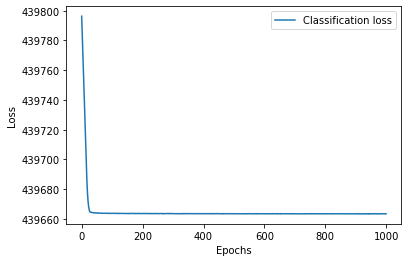

In [144]:
plt.figure()
plt.plot(torso_discriminative.history.history['loss'], label='Classification loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('2021-03-deepCCA-HAR-save/classification-loss_Torso_DiscriminativeModel.svg', format='svg')

In [145]:
y_pred = torso_discriminative.model.predict(train_dict)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = train_labels

/home/dist/hamidi/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['Hips_Pre_m', 'Hips_Acc_m', 'Hips_Gyr_m', 'Hips_Mag_m', 'Hips_Ori_m', 'Hips_Gra_m', 'Hips_LAc_m', 'Bag_Pre_m', 'Bag_Acc_m', 'Bag_Gyr_m', 'Bag_Mag_m', 'Bag_Ori_m', 'Bag_Gra_m', 'Bag_LAc_m', 'Hand_Pre_m', 'Hand_Acc_m', 'Hand_Gyr_m', 'Hand_Mag_m', 'Hand_Ori_m', 'Hand_Gra_m', 'Hand_LAc_m'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


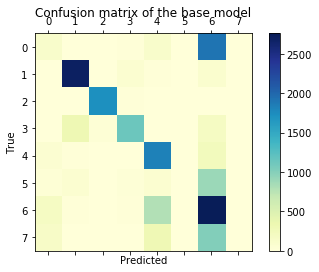

In [146]:
plot_confusionMatrix(y_true, y_pred_class)
plt.savefig('2021-03-deepCCA-HAR-save/confusionMatrix_Torso_DiscriminativeModel.svg')